<h1 style="text-align:center;"> Разработка предложений для покупателей магазина «В один клик»

**Описание проекта:** 
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты.  Активность покупателей начала снижаться. Привлекать новых клиентов не эффективно, необходимо удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Для работы представлено три датасета:

Первый файл содержит информацию о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

Второй файл хранит информацию о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

Третий файл - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Четвертый файл с информацией о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Цель исследования:** 
Разработать модель, которая предскажет вероятность снижения покупательской активности.
С помощью модели нужно выделить перспективный сегмент покупателей и дать рекомендации по увеличению его покупательской активности с учетом данных о прибыли покупателей.

**Ход исследования:**

Загрузка  данных: инициализация необходимых инструментов, загрузка датасетов.

Предобработка данных: изучение общей информации из представленных датасетов, выявление пропущенных значений, дубликатов и других аномалий, группировка и агрегация датасетов. 

Исследовательский анализ данных: анализ структуры данных, распределений, визуализация частоты встречаемости данных, выявление основных тенденций. Отбор клиентов с покупательской активностью не менее трёх месяцев.

Корреляционный анализ данных: выявление зависимостей и их типов.

Использование пайплайнов: подбор модели и гиперпараметров. 
Обучение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

Анализ важности признаков

Выделение сегментов покупателей с использованием результатов моделирования и данных о прибыльности покупателей.

Итоговые выводы: резюмирование полученных результатов, формулировка рекомендаций и персонализированных предложения для сегментов покупателей.


## Загрузка данных

In [1]:
!pip install ydata-profiling

In [2]:
!pip install matplotlib==3.7.3

In [3]:
#!pip install --upgrade Pillow

In [4]:
!pip install phik -q # -q убирает необязательные выводы в командах Linux

In [5]:
!pip install shap

In [6]:
!pip install scikit-learn==1.0.0

In [7]:
import pandas as pd
#pd.set_option('max_columns', None)

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler, 
    RobustScaler, 
    StandardScaler)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score 

import shap

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 77
TEST_SIZE = 0.25


In [8]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal=",")

In [9]:
market_file.sample(5)

id Покупательская активность Тип сервиса Разрешить сообщать  \
770  216118           Прежний уровень    стандарт                 да   
947  216295           Прежний уровень    стандарт                нет   
335  215683                 Снизилась     премиум                 да   
324  215672                 Снизилась    стандарт                 да   
773  216121           Прежний уровень    стандарт                 да   

     Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
770                 3.6                     4           417   
947                 5.1                     3           712   
335                 4.4                     4           190   
324                 4.4                     5           261   
773                 5.0                     5           334   

     Акционные_покупки                  Популярная_категория  \
770               0.30                      Товары для детей   
947               0.33  Мелкая бытовая техника и электроника   
335               0.13                     Домашний текстиль   
324               0.31                       Кухонная посуда   
773               0.14                     Домашний текстиль   

     Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
770                                    5                                   5   
947                                    2                                   1   
335                                    1                                   4   
324                                    1                                   6   
773                                    3                                   3   

     Ошибка_сервиса  Страниц_за_визит  
770               2                 9  
947               1                10  
335               2                10  
324               1                 2  
773               4                14

In [10]:
market_money.sample(5)

id               Период  Выручка
256   215433  препредыдущий_месяц   4098.0
2367  216137     предыдущий_месяц   5569.0
3669  216571     предыдущий_месяц   4772.5
865   215636        текущий_месяц   6125.0
461   215501        текущий_месяц   6758.7

In [11]:
market_time.sample(5)

id            Период  минут
1859  216277     текущий_месяц     14
284   215490  предыдцщий_месяц     13
2308  216502  предыдцщий_месяц     14
1610  216153     текущий_месяц     17
1558  216127     текущий_месяц     17

In [12]:
money.sample(5)

id  Прибыль
953  216301     4.34
741  216089     3.58
580  215928     3.66
78   215426     4.66
947  216295     2.68

`Прочитаны файлы для работы. Данные в таблицах соответствуют описанию. Все загрузки оттобразились корректно, для файла money указаны разделители: разделитель значений — с точка с запятой, а разделитель десятичных значений — запятая.` 

## Предобработка данных

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [14]:
market_file['id'].nunique()

1300

In [15]:
market_file.describe(include='object').T

count unique               top freq
Покупательская активность  1300      2   Прежний уровень  802
Тип сервиса                1300      3          стандарт  914
Разрешить сообщать         1300      2                да  962
Популярная_категория       1300      6  Товары для детей  330

In [16]:
#В столбце Тип сервиса определяется 3 категории, требуются исправления
market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [17]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт','стандарт')

In [18]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [19]:
market_file.describe(include='object').T

count unique               top freq
Покупательская активность  1300      2   Прежний уровень  802
Тип сервиса                1300      2          стандарт  924
Разрешить сообщать         1300      2                да  962
Популярная_категория       1300      6  Товары для детей  330

In [20]:
market_file.describe().T

count           mean         std  \
id                                   1300.0  215997.500000  375.421985   
Маркет_актив_6_мес                   1300.0       4.253769    1.014814   
Маркет_актив_тек_мес                 1300.0       4.011538    0.696868   
Длительность                         1300.0     601.898462  249.856289   
Акционные_покупки                    1300.0       0.319808    0.249843   
Средний_просмотр_категорий_за_визит  1300.0       3.270000    1.355350   
Неоплаченные_продукты_штук_квартал   1300.0       2.840000    1.971451   
Ошибка_сервиса                       1300.0       4.185385    1.955298   
Страниц_за_визит                     1300.0       8.176923    3.978126   

                                          min        25%        50%  \
id                                   215348.0  215672.75  215997.50   
Маркет_актив_6_мес                        0.9       3.70       4.20   
Маркет_актив_тек_мес                      3.0       4.00       4.00   
Длительность                            110.0     405.50     606.00   
Акционные_покупки                         0.0       0.17       0.24   
Средний_просмотр_категорий_за_визит       1.0       2.00       3.00   
Неоплаченные_продукты_штук_квартал        0.0       1.00       3.00   
Ошибка_сервиса                            0.0       3.00       4.00   
Страниц_за_визит                          1.0       5.00       8.00   

                                           75%        max  
id                                   216322.25  216647.00  
Маркет_актив_6_мес                        4.90       6.60  
Маркет_актив_тек_мес                      4.00       5.00  
Длительность                            806.00    1079.00  
Акционные_покупки                         0.30       0.99  
Средний_просмотр_категорий_за_визит       4.00       6.00  
Неоплаченные_продукты_штук_квартал        4.00      10.00  
Ошибка_сервиса                            6.00       9.00  
Страниц_за_визит                         11.00      20.00

In [21]:
market_file.duplicated().sum()

0

In [22]:
#Если перевести ID в индекс, то появляется 11 дубликатов. Перевод пока нецелесообразен
#market_file = market_file.set_index('id')
#df = df.drop_duplicates().reset_index(drop=True) 

Первый файл market_file содержит 1300 уникальных записей. Количественные данные полные, без явных выбросов.
В столбце Тип сервиса исправила опечатку.
Отмечается дисбаланс классов: покупательская активность - прежний уровень, тип сервиса - стандарт, разрешить сообщать - да.
Категориальные столбцы (Покупательская активность, Разрешить сообщать) при необходимости можно преобразовать в булевые.

In [23]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [24]:
market_money['id'].nunique()

1300

In [25]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [26]:
market_money.describe().T

count           mean          std       min        25%       50%  \
id       3900.0  215997.500000   375.325686  215348.0  215672.75  215997.5   
Выручка  3900.0    5025.696051  1777.704104       0.0    4590.15    4957.5   

               75%       max  
id       216322.25  216647.0  
Выручка    5363.00  106862.2

In [27]:
market_money.duplicated().sum()

0

Второй файл market_money содержит 3900 уникальных записей. Количественные данные полные, без явных выбросов.
В столбце Период 3 категории, количество ID 1300, значит по каждому пользователю представлены 3 строчки данных, по одной за каждый период.
По выручке явных выбросов нет, дубликатов нет.

In [28]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [29]:
market_time['id'].nunique()

1300

In [30]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [31]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')

In [32]:
market_time.describe().T

count           mean         std       min        25%       50%  \
id     2600.0  215997.500000  375.349754  215348.0  215672.75  215997.5   
минут  2600.0      13.336154    4.080198       4.0      10.00      13.0   

             75%       max  
id     216322.25  216647.0  
минут      16.00      23.0

In [33]:
market_time.duplicated().sum()

0

Третий файл market_time содержит 2600 уникальных записей. Количественные данные полные, без явных выбросов.
В столбце Период 2 категории, количество ID 1300, значит по каждому пользователю представлены 2 строчки данных, по одной за каждый период.
По минутам явных выбросов нет, дубликатов нет.

In [34]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [35]:
money['id'].nunique()

1300

In [36]:
money.describe().T

count           mean         std        min        25%         50%  \
id       1300.0  215997.500000  375.421985  215348.00  215672.75  215997.500   
Прибыль  1300.0       3.996631    1.013722       0.86       3.30       4.045   

               75%        max  
id       216322.25  216647.00  
Прибыль       4.67       7.43

Четвертый файл money содержит 1300 уникальных записей. Количественные данные полные, без явных выбросов.

In [37]:
market_money = market_money.pivot_table(index=['id'], columns=['Период'])
market_money.columns = ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
#market_money

In [38]:
market_money = market_money.reindex(columns=['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц'])
#market_money

In [39]:
market = market_file.merge(market_money, on='id')
market.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0                          0.0                       0.0   
1                       4472.0                    5216.0   
2                       4826.0                    5457.5   
3                       4793.0                    6158.0   
4                       4594.0                    5807.5   

   Выручка_текущий_месяц  
0                 3293.1  
1                 4971.6  
2                 5058.4  
3                 6610.4  
4                 5872.5

In [40]:
market_time = market_time.pivot_table(index=['id'], columns=['Период'])
market_time.columns = ['Время_в_предыдущем_месяце_мин', 'Время_в_текущем_месяце_мин']
#market_time

In [41]:
market = market.merge(market_time, on='id')
market.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0                          0.0                       0.0   
1                       4472.0                    5216.0   
2                       4826.0                    5457.5   
3                       4793.0                    6158.0   
4                       4594.0                    5807.5   

   Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
0                 3293.1                           13.0   
1                 4971.6                           12.0   
2                 5058.4                            8.0   
3                 6610.4                           11.0   
4                 5872.5                            8.0   

   Время_в_текущем_месяце_мин  
0                        14.0  
1                        10.0  
2                        13.0  
3                        13.0  
4                        11.0

In [42]:
#Для обзора и исследовательского анализа данных использую новый для меня инструмент ydata-profiling
market_pro = ProfileReport(market, title="Profiling Report")

In [43]:
market_pro.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
#в файл
market_pro.to_file("report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

`На основании изучения общей информации из представленных датасетов установлено, что к анализу представлены данные о 1300 покупателях. Данные полные, без пропусков и дубликатов. Корректировка наименований столбцов не требуется. Размерность файлов определена корректно. Данные с дисбалансом классов. Данные по выручке представлены за 3 месяца. Время, проведенно на сайте, представлено за 2 месяца. По прибыли период общий - 3 месяца.`
`Для облегчения проведения исследовательского анализа объединила данные из трах файлов врабочий датасет market`

## Исследовательский анализ данных

Исследовательский анализ проведу с учетом данных профайлинга. 
Для наглядности визуализацию сделаю дополнительно.

In [45]:
cat_cols_market = ['Покупательская активность', 
                   'Тип сервиса', 
                   'Разрешить сообщать', 
                   'Популярная_категория']
titles_cat = ['Покупательская активность', 'Тип сервиса', 'Рассылка доп. предложений', 'Популярная категория']

In [46]:
num_cols_market = ['Маркет_актив_6_мес', 
                   'Длительность', 
                   'Акционные_покупки',
                  'Выручка_препредыдущий_месяц',
                  'Выручка_предыдущий_месяц',
                  'Выручка_текущий_месяц',
                  'Время_в_предыдущем_месяце_мин',
                  'Время_в_текущем_месяце_мин']
titles_num = ['Cреднемесячное число маркетинговых коммуникаций за 6 месяцев',
              'Длительность', 
              'Среднемесячная доля акционнх покупок',
             'Выручка_препредыдущий_месяц',
             'Выручка_предыдущий_месяц',
             'Выручка_текущий_месяц',
             'Время_в_предыдущем_месяце_мин',
             'Время_в_текущем_месяце_мин']

In [47]:
#Эти категории представлены дискретными числами.  
#Выделила их отдельно, т.к. по сути это категориальные переменные. 
num_cols_d_market = ['Маркет_актив_тек_мес',
                     'Средний_просмотр_категорий_за_визит', 
                     'Неоплаченные_продукты_штук_квартал', 
                     'Ошибка_сервиса', 
                     'Страниц_за_визит']
titles_num_d = ['Количество маркетинговых коммуникаций в текущем месяце', 
                'Количество просмотров категорий за визит за месяц', 
                'Неоплаченные продукты за 3 месяца',
               'Ошибка сервиса',
              'Количество страниц за визит']

In [48]:
colors = sns.color_palette('pastel')

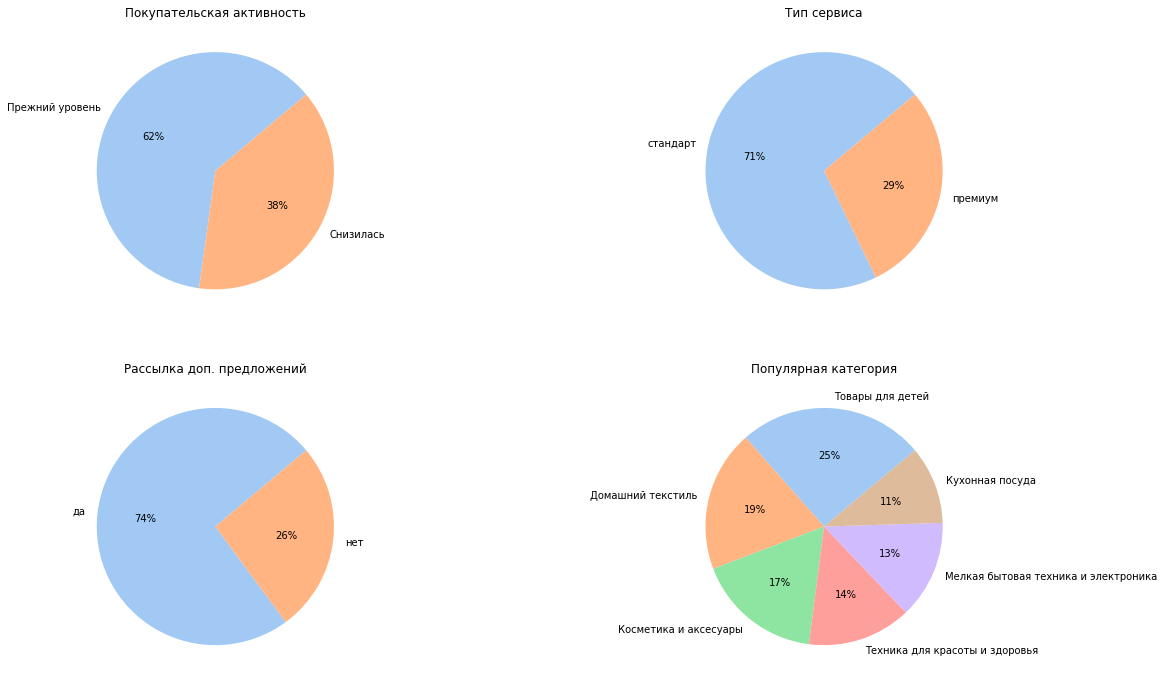

In [49]:
#визуализация качественных признаков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.ravel()  

for col, color, title, ax in zip(cat_cols_market, colors, titles_cat, axes):
    market_file[col].value_counts().plot(kind = 'pie', colors=colors, autopct = '%1.0f%%', startangle=40, ax=ax )
    ax.set_title(title)
    ax.axes.yaxis.set_visible(False)
    
    
#fig.delaxes(axes[5])  
plt.show()

Данные представлены четырьмя категориальными признаками. Наглядно продемонстрирован дисбаланс классов. Все классы достаточно репрезентативны. Признак "Популярная категория" представлен достаточно равномерно.

In [50]:
#функция для параллельного построения гистограммы и ящика с усами для количественных непрерывных признаков
def hist_boxplot(data, column, title):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.title(f'{title}')
    plt.grid(True)
    sns.set(style="ticks")
    sns.color_palette('pastel')
    sns.histplot(data[column], color='crimson', kde=True)
    plt.subplot(1, 2, 2)
    plt.xlabel('')
    plt.title(f' {title}')
    plt.grid(True)
    sns.set(style="darkgrid")
    sns.boxplot(x=data[column])
    plt.tight_layout()
    plt.show()

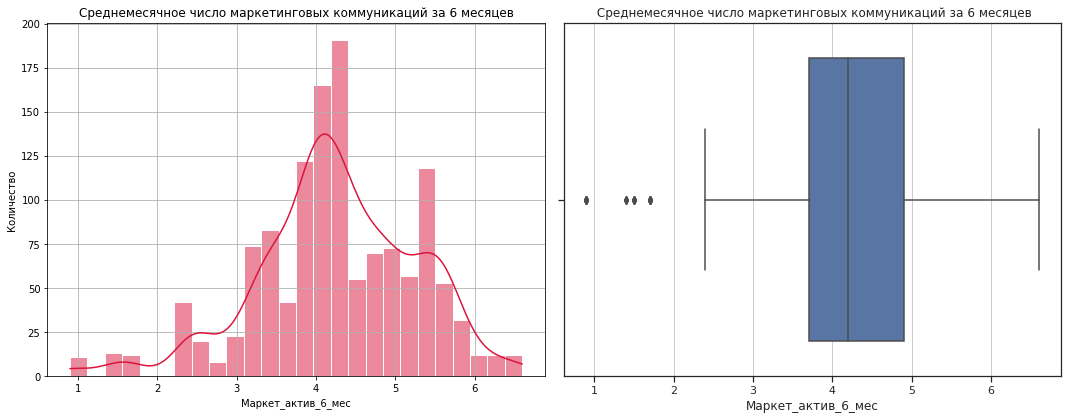

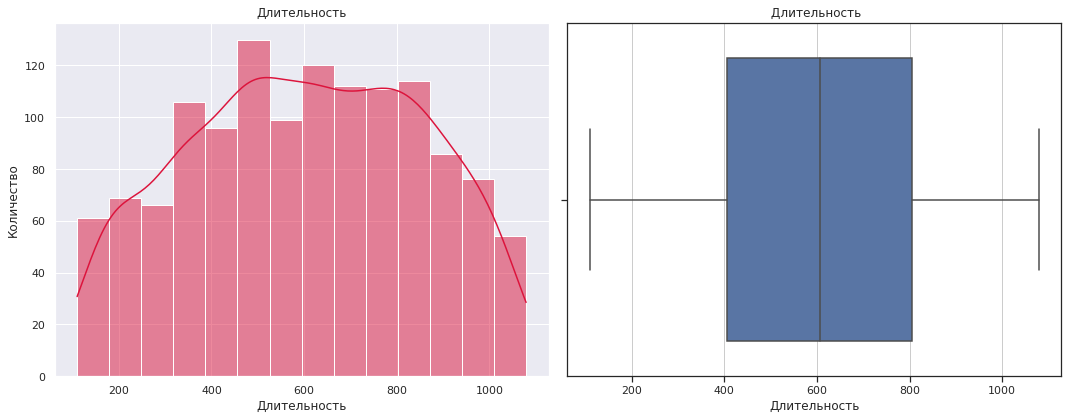

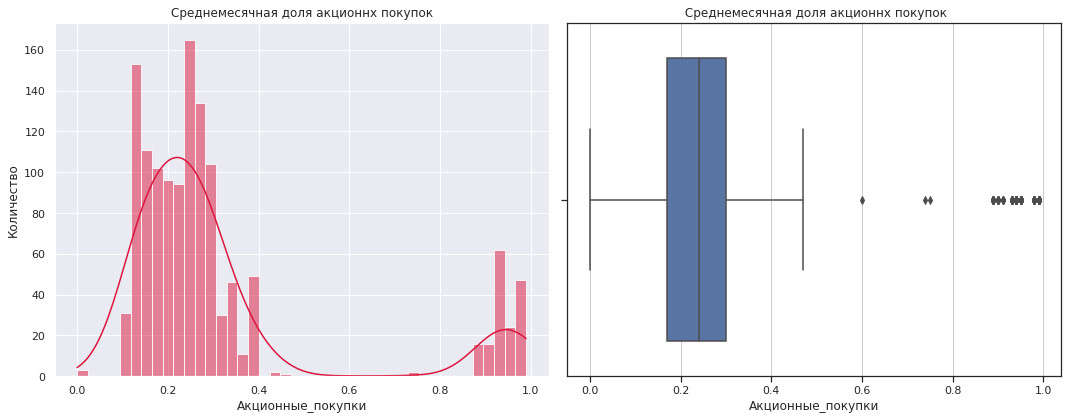

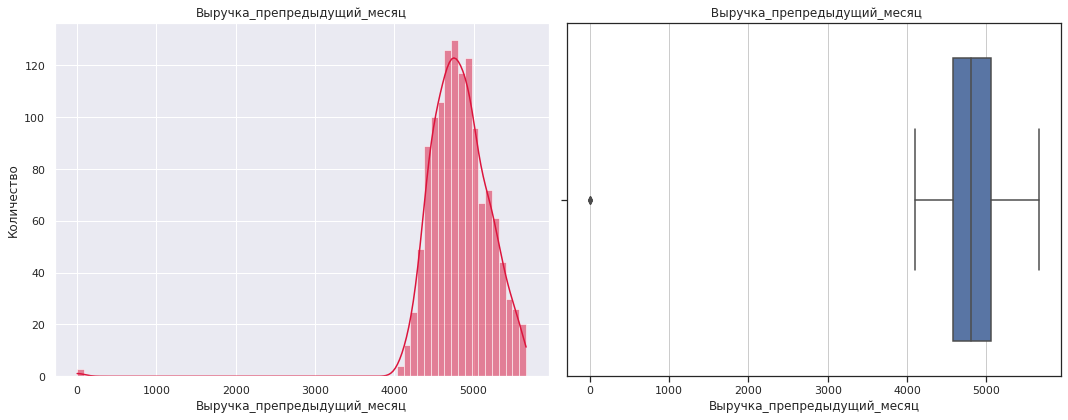

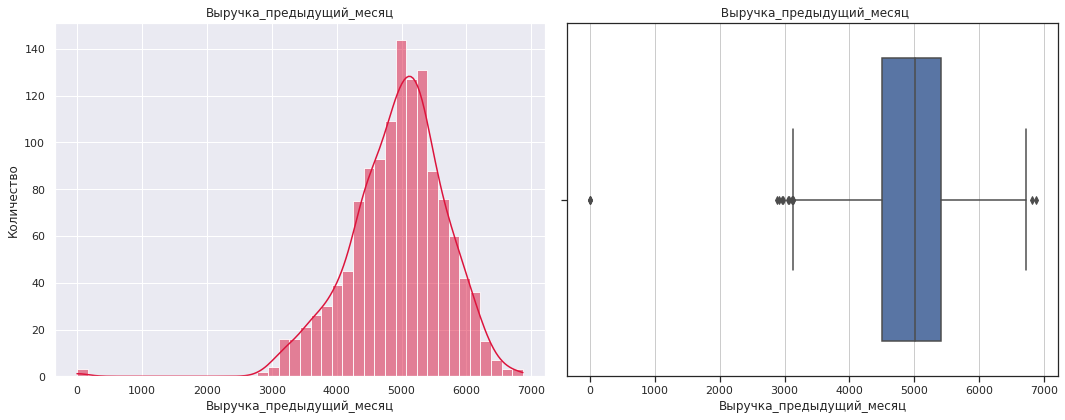

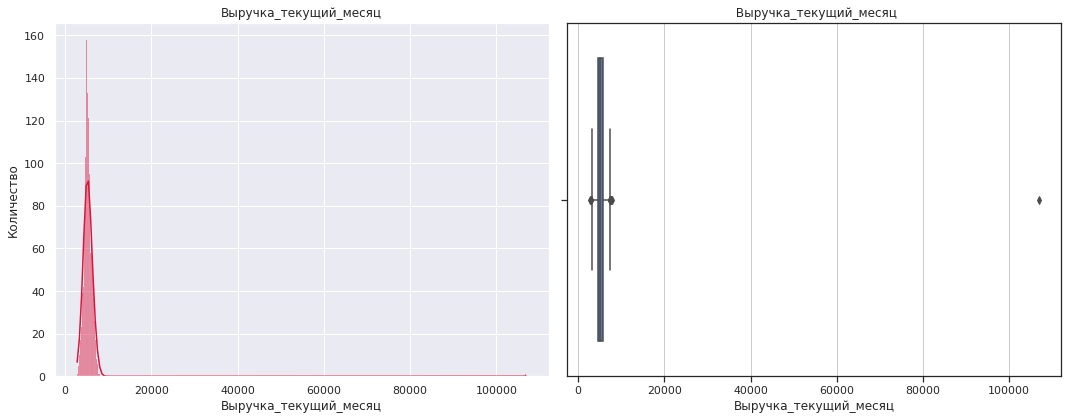

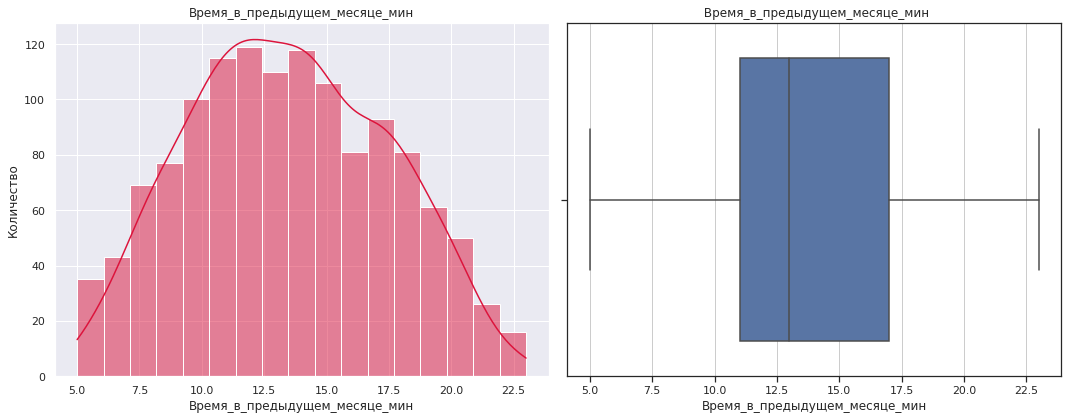

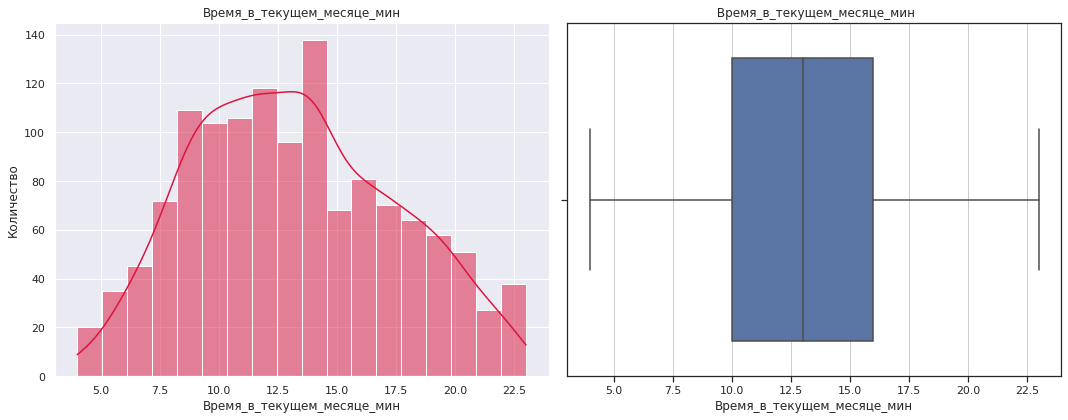

In [51]:
#визуализация количественных непрерывных признаков market
for col, title in zip(num_cols_market, titles_num):
    hist_boxplot(market, col, title)

In [52]:
market[market['Выручка_текущий_месяц'] > 100000]

id Покупательская активность Тип сервиса Разрешить сообщать  \
32  215380                 Снизилась     премиум                нет   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
32                 1.7                     4           637               0.94   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
32  Техника для красоты и здоровья                                    3   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
32                                   2               4                 7   

    Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
32                       5051.0                    6077.0   

    Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
32               106862.2                           12.0   

    Время_в_текущем_месяце_мин  
32                        14.0

In [53]:
market.loc[32, 'Выручка_текущий_месяц']= market['Выручка_текущий_месяц'].median()

In [54]:
market.loc[32:32, ]

id Покупательская активность Тип сервиса Разрешить сообщать  \
32  215380                 Снизилась     премиум                нет   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
32                 1.7                     4           637               0.94   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
32  Техника для красоты и здоровья                                    3   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
32                                   2               4                 7   

    Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
32                       5051.0                    6077.0   

    Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
32                5179.95                           12.0   

    Время_в_текущем_месяце_мин  
32                        14.0

In [55]:
def num_d(dataset, column, title):
    plt.figure()
    sns.countplot(x=dataset[column])
    plt.title(f'{title}')
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.grid(True)

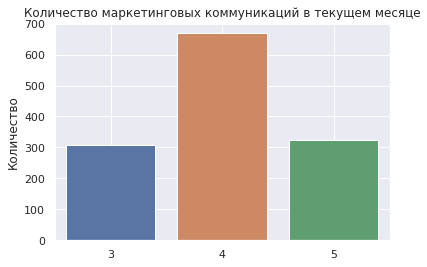

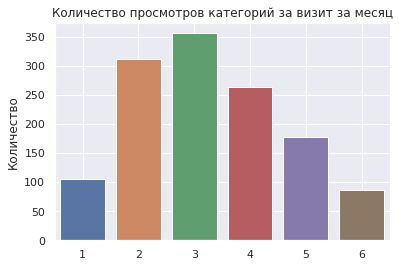

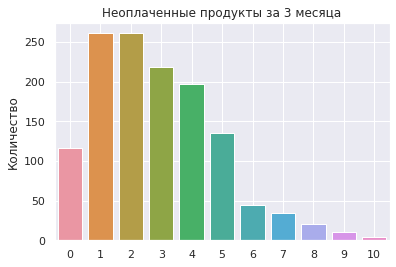

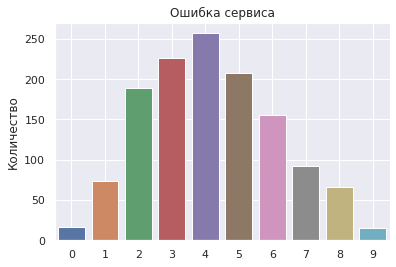

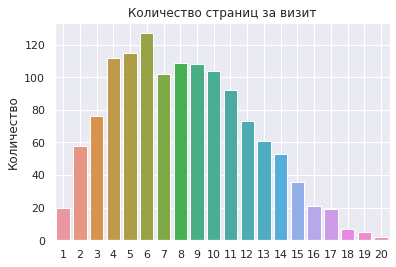

In [56]:
#визуализация количественных дискретных признаков market
for col, tit in zip(num_cols_d_market, titles_num_d):
    num_d(market_file, col, tit)

In [57]:
num_col_money = ['Прибыль']
titles_num = ['Прибыль']

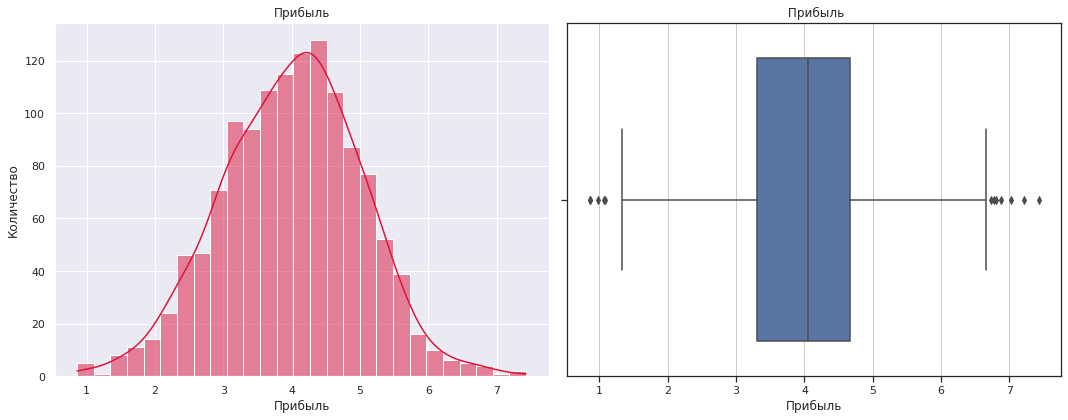

In [58]:
#визуализация количественных непрерывных признаков money
for col, title in zip(num_col_money, titles_num):
    hist_boxplot(money, col, title)

Данные о количественных признаках имеют нормальное распределение. Присутствуют некоторые незначительные выбросы, которые не требуют удаления. Однако, по показателям выручки есть одна аномалия (заполнила медианой) и есть пользователи с нулевой выручкой. 
Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев содержит значения, которые ящик с усами воспринимает как выбросы. Однако, возможно, эти значения могут быть критерием для сегментации покупателей на тех, кто часто и редко совершает покупки по акции.
Дискретные количественные признаки могут быть использованы как категории сегментации.

Данные о прибыли распределены нормально, есть небольшое количество выбросов с двух сторон.

Для исследования необходимо отобрать только тех клиентов, у которых прослеживается покупательская активностью не менее трёх месяцев.

In [59]:
market.query('Выручка_препредыдущий_месяц == 0')

id Покупательская активность Тип сервиса Разрешить сообщать  \
0   215348                 Снизилась     премиум                 да   
9   215357                 Снизилась    стандарт                 да   
11  215359                 Снизилась    стандарт                 да   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                  3.4                     5           121                0.0   
9                  3.9                     5           154                0.0   
11                 4.6                     5           110                0.0   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                 Товары для детей                                    6   
9   Техника для красоты и здоровья                                    3   
11               Домашний текстиль                                    4   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                    2               1                 5   
9                                    3               9                 5   
11                                   2               4                 2   

    Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0                           0.0                       0.0   
9                           0.0                       0.0   
11                          0.0                       0.0   

    Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
0                  3293.1                           13.0   
9                  5986.3                           12.0   
11                 4735.0                           13.0   

    Время_в_текущем_месяце_мин  
0                         14.0  
9                          6.0  
11                        11.0

Всего три покупателя не соответствуют критерию отбора. Исключим их из анализа.

In [60]:
market = market.query('id != [215348, 215357, 215359]')
market.shape


(1297, 18)

In [61]:
market = market.set_index('id')
market.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215349                       4472.0                    5216.0   
215350                       4826.0                    5457.5   
215351                       4793.0                    6158.0   
215352                       4594.0                    5807.5   
215353                       5124.0                    4738.5   

        Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
id                                                             
215349                 4971.6                           12.0   
215350                 5058.4                            8.0   
215351                 6610.4                           11.0   
215352                 5872.5                            8.0   
215353                 5388.5                           10.0   

        Время_в_текущем_месяце_мин  
id                                  
215349                        10.0  
215350                        13.0  
215351                        13.0  
215352                        11.0  
215353                        10.0

## Корреляционный анализ данных

Для наглядного представления корреляции между показателями рассмотрим матрицу корреляций phik.

In [62]:
# создаём список с наименованиями непрерывных признаков
interval_cols = num_cols_market
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(market, interval_cols=interval_cols) 

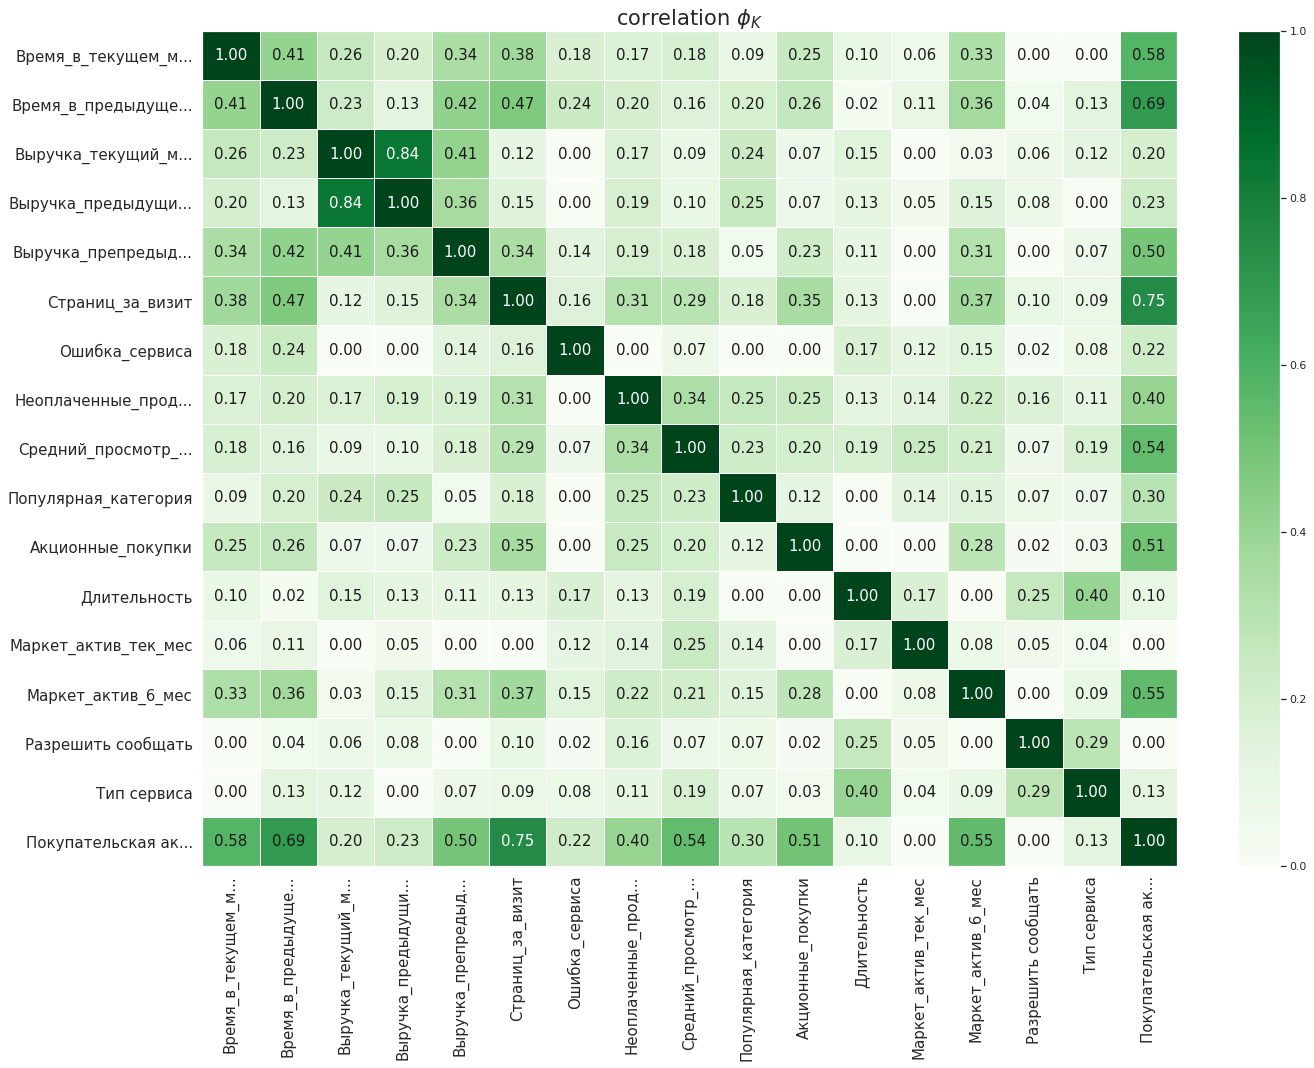

In [63]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Есть линейная зависимость между выручкой в текущем и предыдущем месяце. Корреляция 0.86 (меньше 0.9).  Значит мультиколлинеарности нет. 

In [64]:
X = market[['Выручка_препредыдущий_месяц', 
           'Выручка_предыдущий_месяц',
           'Выручка_текущий_месяц', 
           'Страниц_за_визит', 
           'Время_в_предыдущем_месяце_мин']]

# Добавляем константу к независимым переменным
X_with_const = add_constant(X)

# Создаём DataFrame для хранения VIF, включая 'const'
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns

# Вычисляем VIF для каждой переменной, включая константу
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

# Опционально: удаляем строку с константой, если она не нужна в выводе
vif_data = vif_data[vif_data["feature"] != "const"]

vif_data

feature       VIF
1    Выручка_препредыдущий_месяц  1.491870
2       Выручка_предыдущий_месяц  4.205876
3          Выручка_текущий_месяц  3.769907
4               Страниц_за_визит  1.291887
5  Время_в_предыдущем_месяце_мин  1.352827

Как правило, значение VIF выше 5 требует внимания, а выше 10 — серьёзного рассмотрения изменений в модели. Коэффициент инфляции дисперсии (VIF) для столбца 'Выручка_предыдущий_месяц' принимает самое болшое значение в 4,2 пункта. Однако, это значение не превышает 5.

Отмечается взаимосвязь между временем, проведенным на сайте, и количеством посещенных страниц. Данные зависимости имеют логическое объяснение.
Целевой признак - покупательская активность. Он имеет высокую корреляцию с количеством страниц за визит и временем, проведенным на сайте. Признаки между собой относительно независимы.

Изучим зависимости между покупательской активностью и количественными признаками признаками под влиянием качественных. Сделаем обзор графиков.

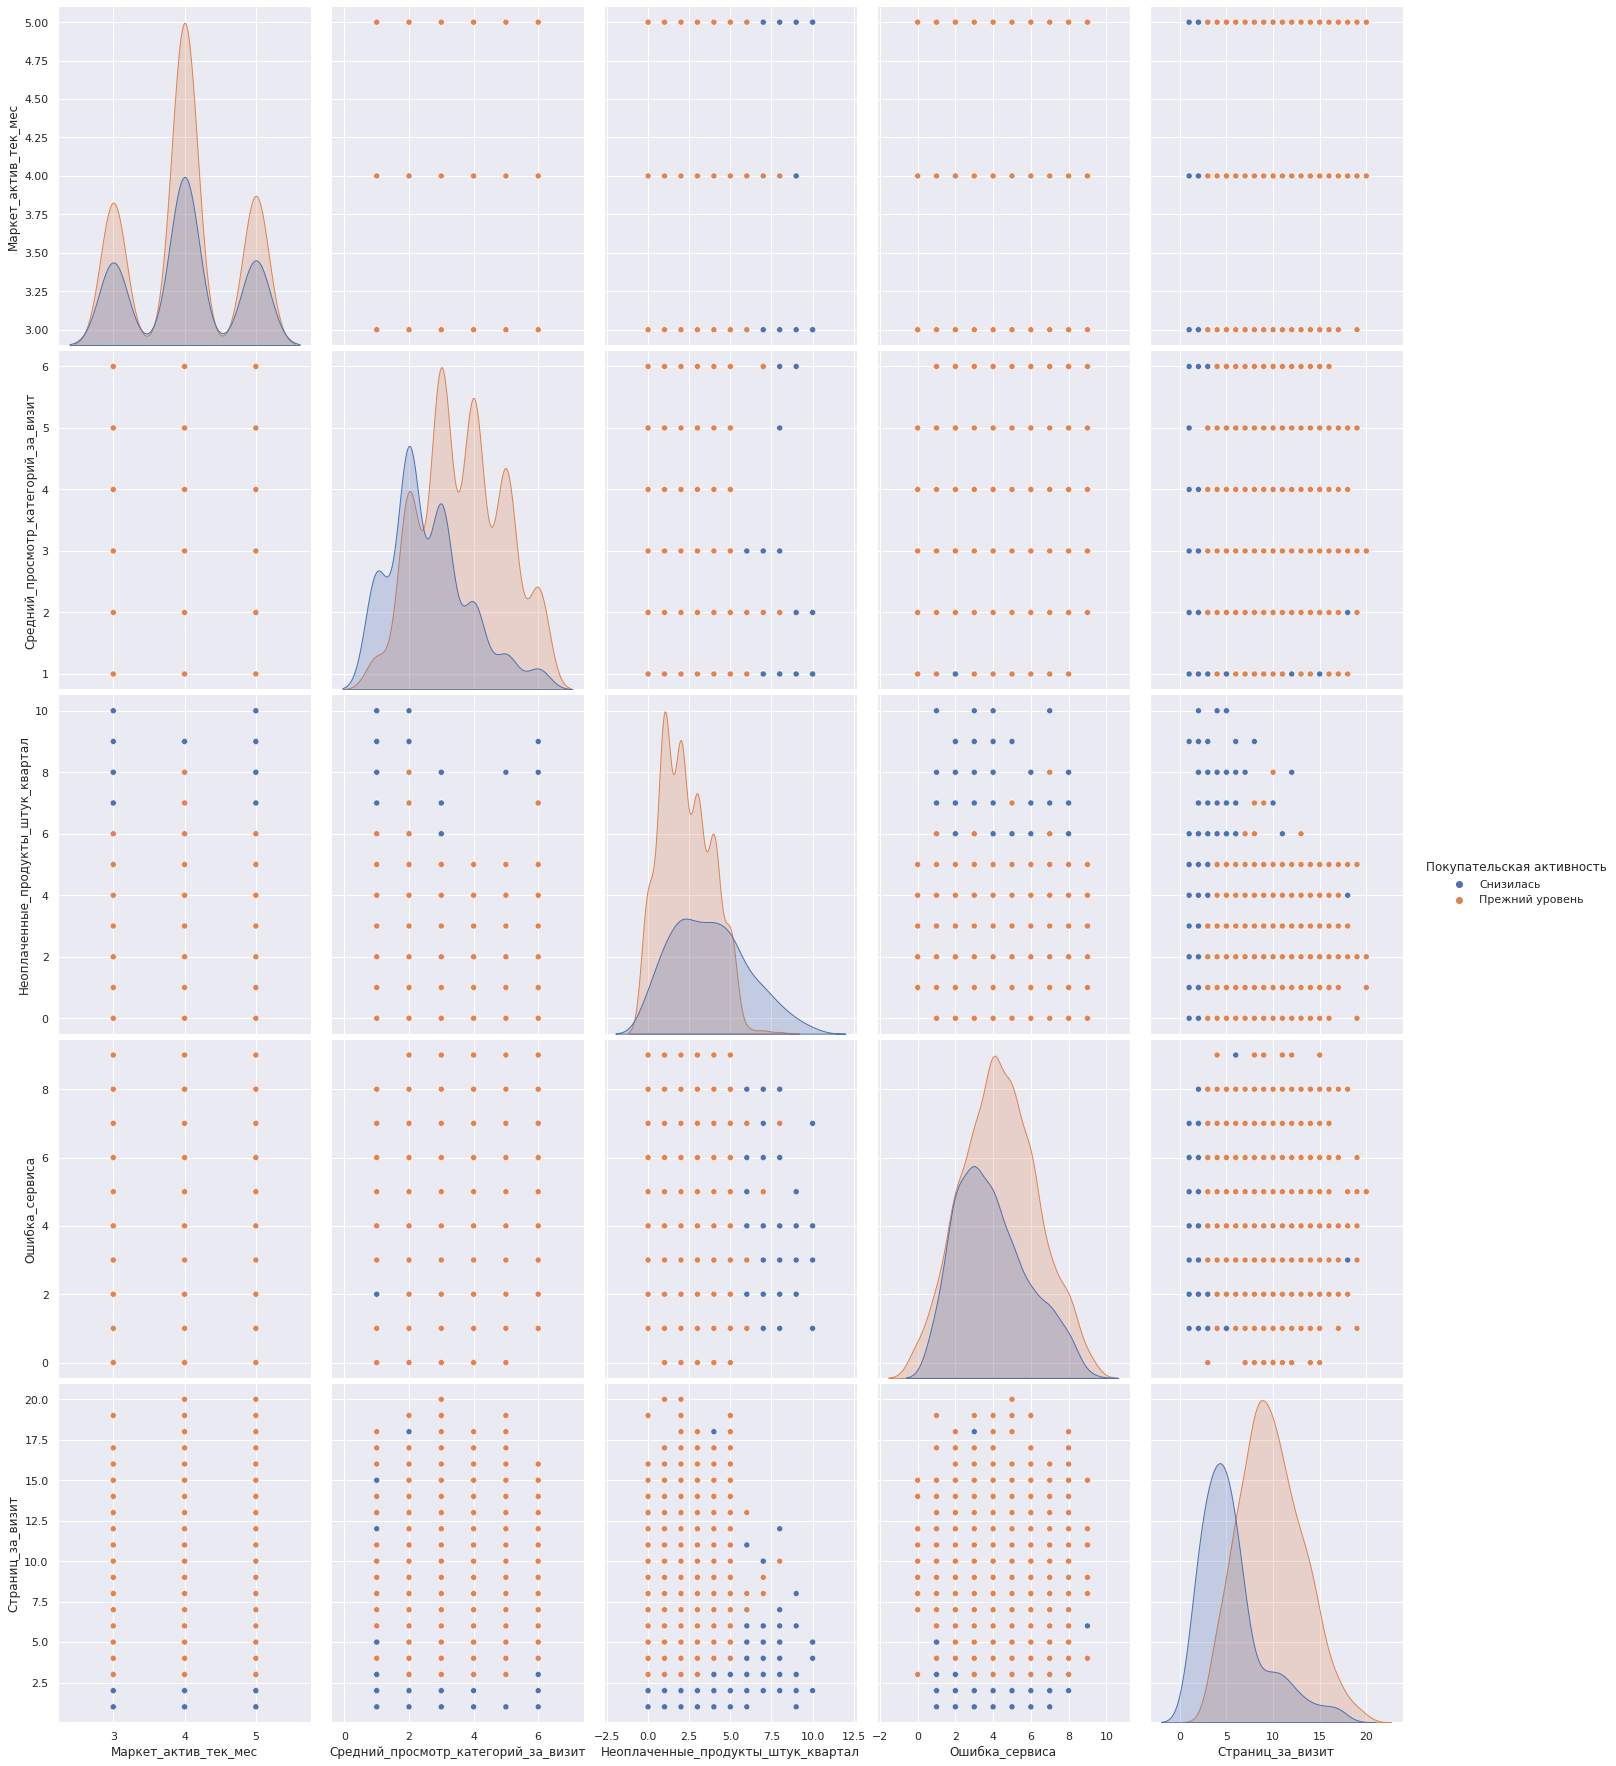

In [65]:
sns.pairplot(market[num_cols_d_market+['Покупательская активность']], 
             hue = 'Покупательская активность',
             height=5,
             aspect=0.8)
plt.show()

Данные не смешиваются, можно сделать вывод о наличии закономерностей между покупательской активностью и дискретными (категориальными) признаками.

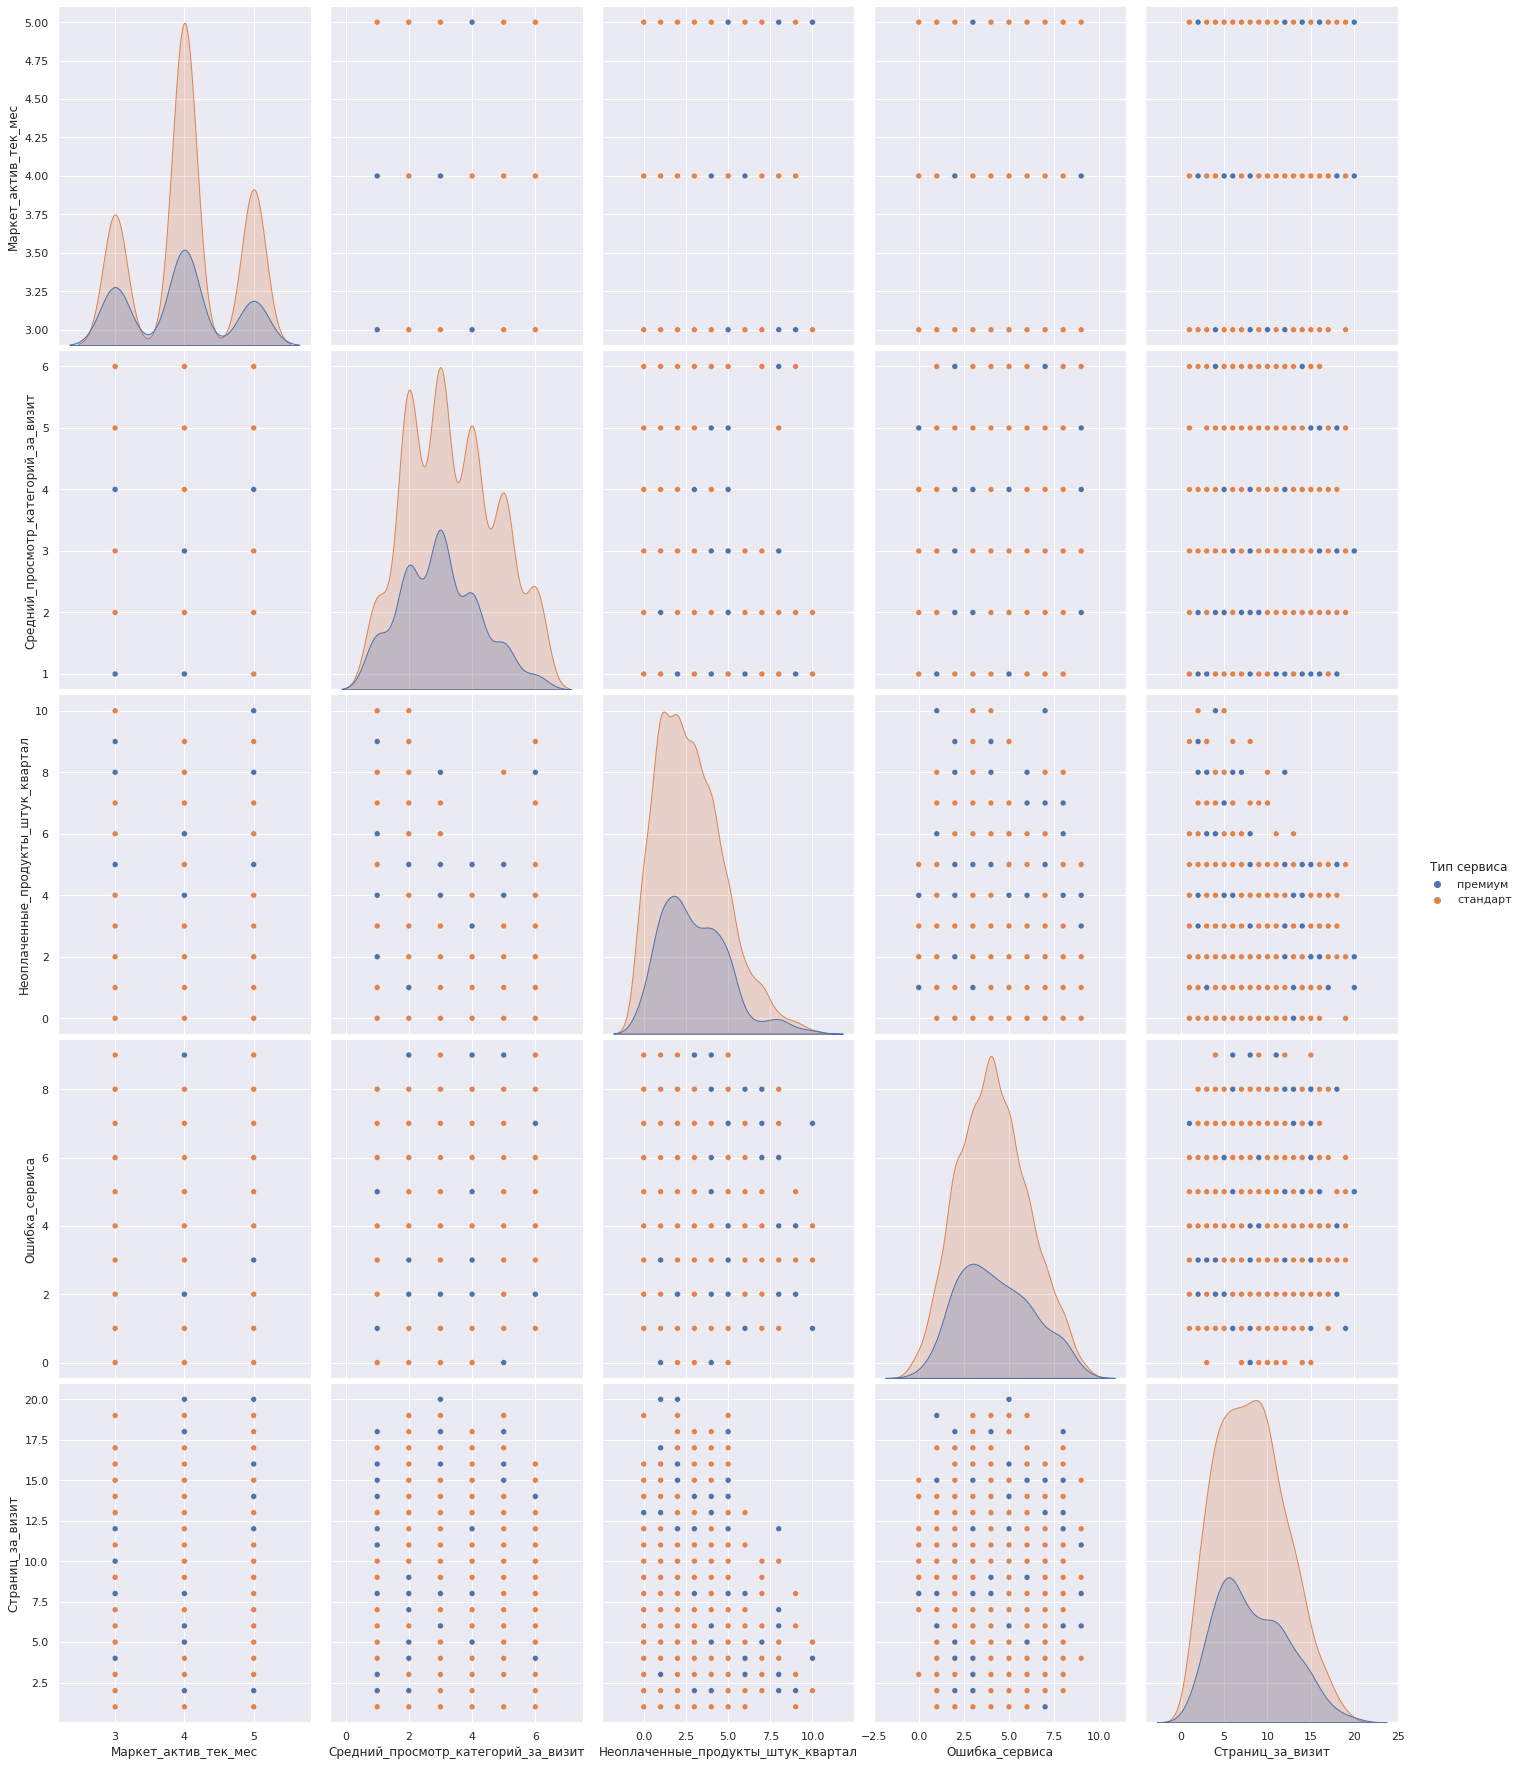

In [66]:
sns.pairplot(market[num_cols_d_market+['Тип сервиса']], 
             hue = 'Тип сервиса',
             height=5,
             aspect=0.8)
plt.show()

In [67]:
num_cols_market = ['Маркет_актив_6_мес', 
                   'Длительность', 
                   'Акционные_покупки',
                  'Выручка_препредыдущий_месяц',
                  'Выручка_предыдущий_месяц',
                  'Выручка_текущий_месяц',
                  'Время_в_предыдущем_месяце_мин',
                  'Время_в_текущем_месяце_мин']

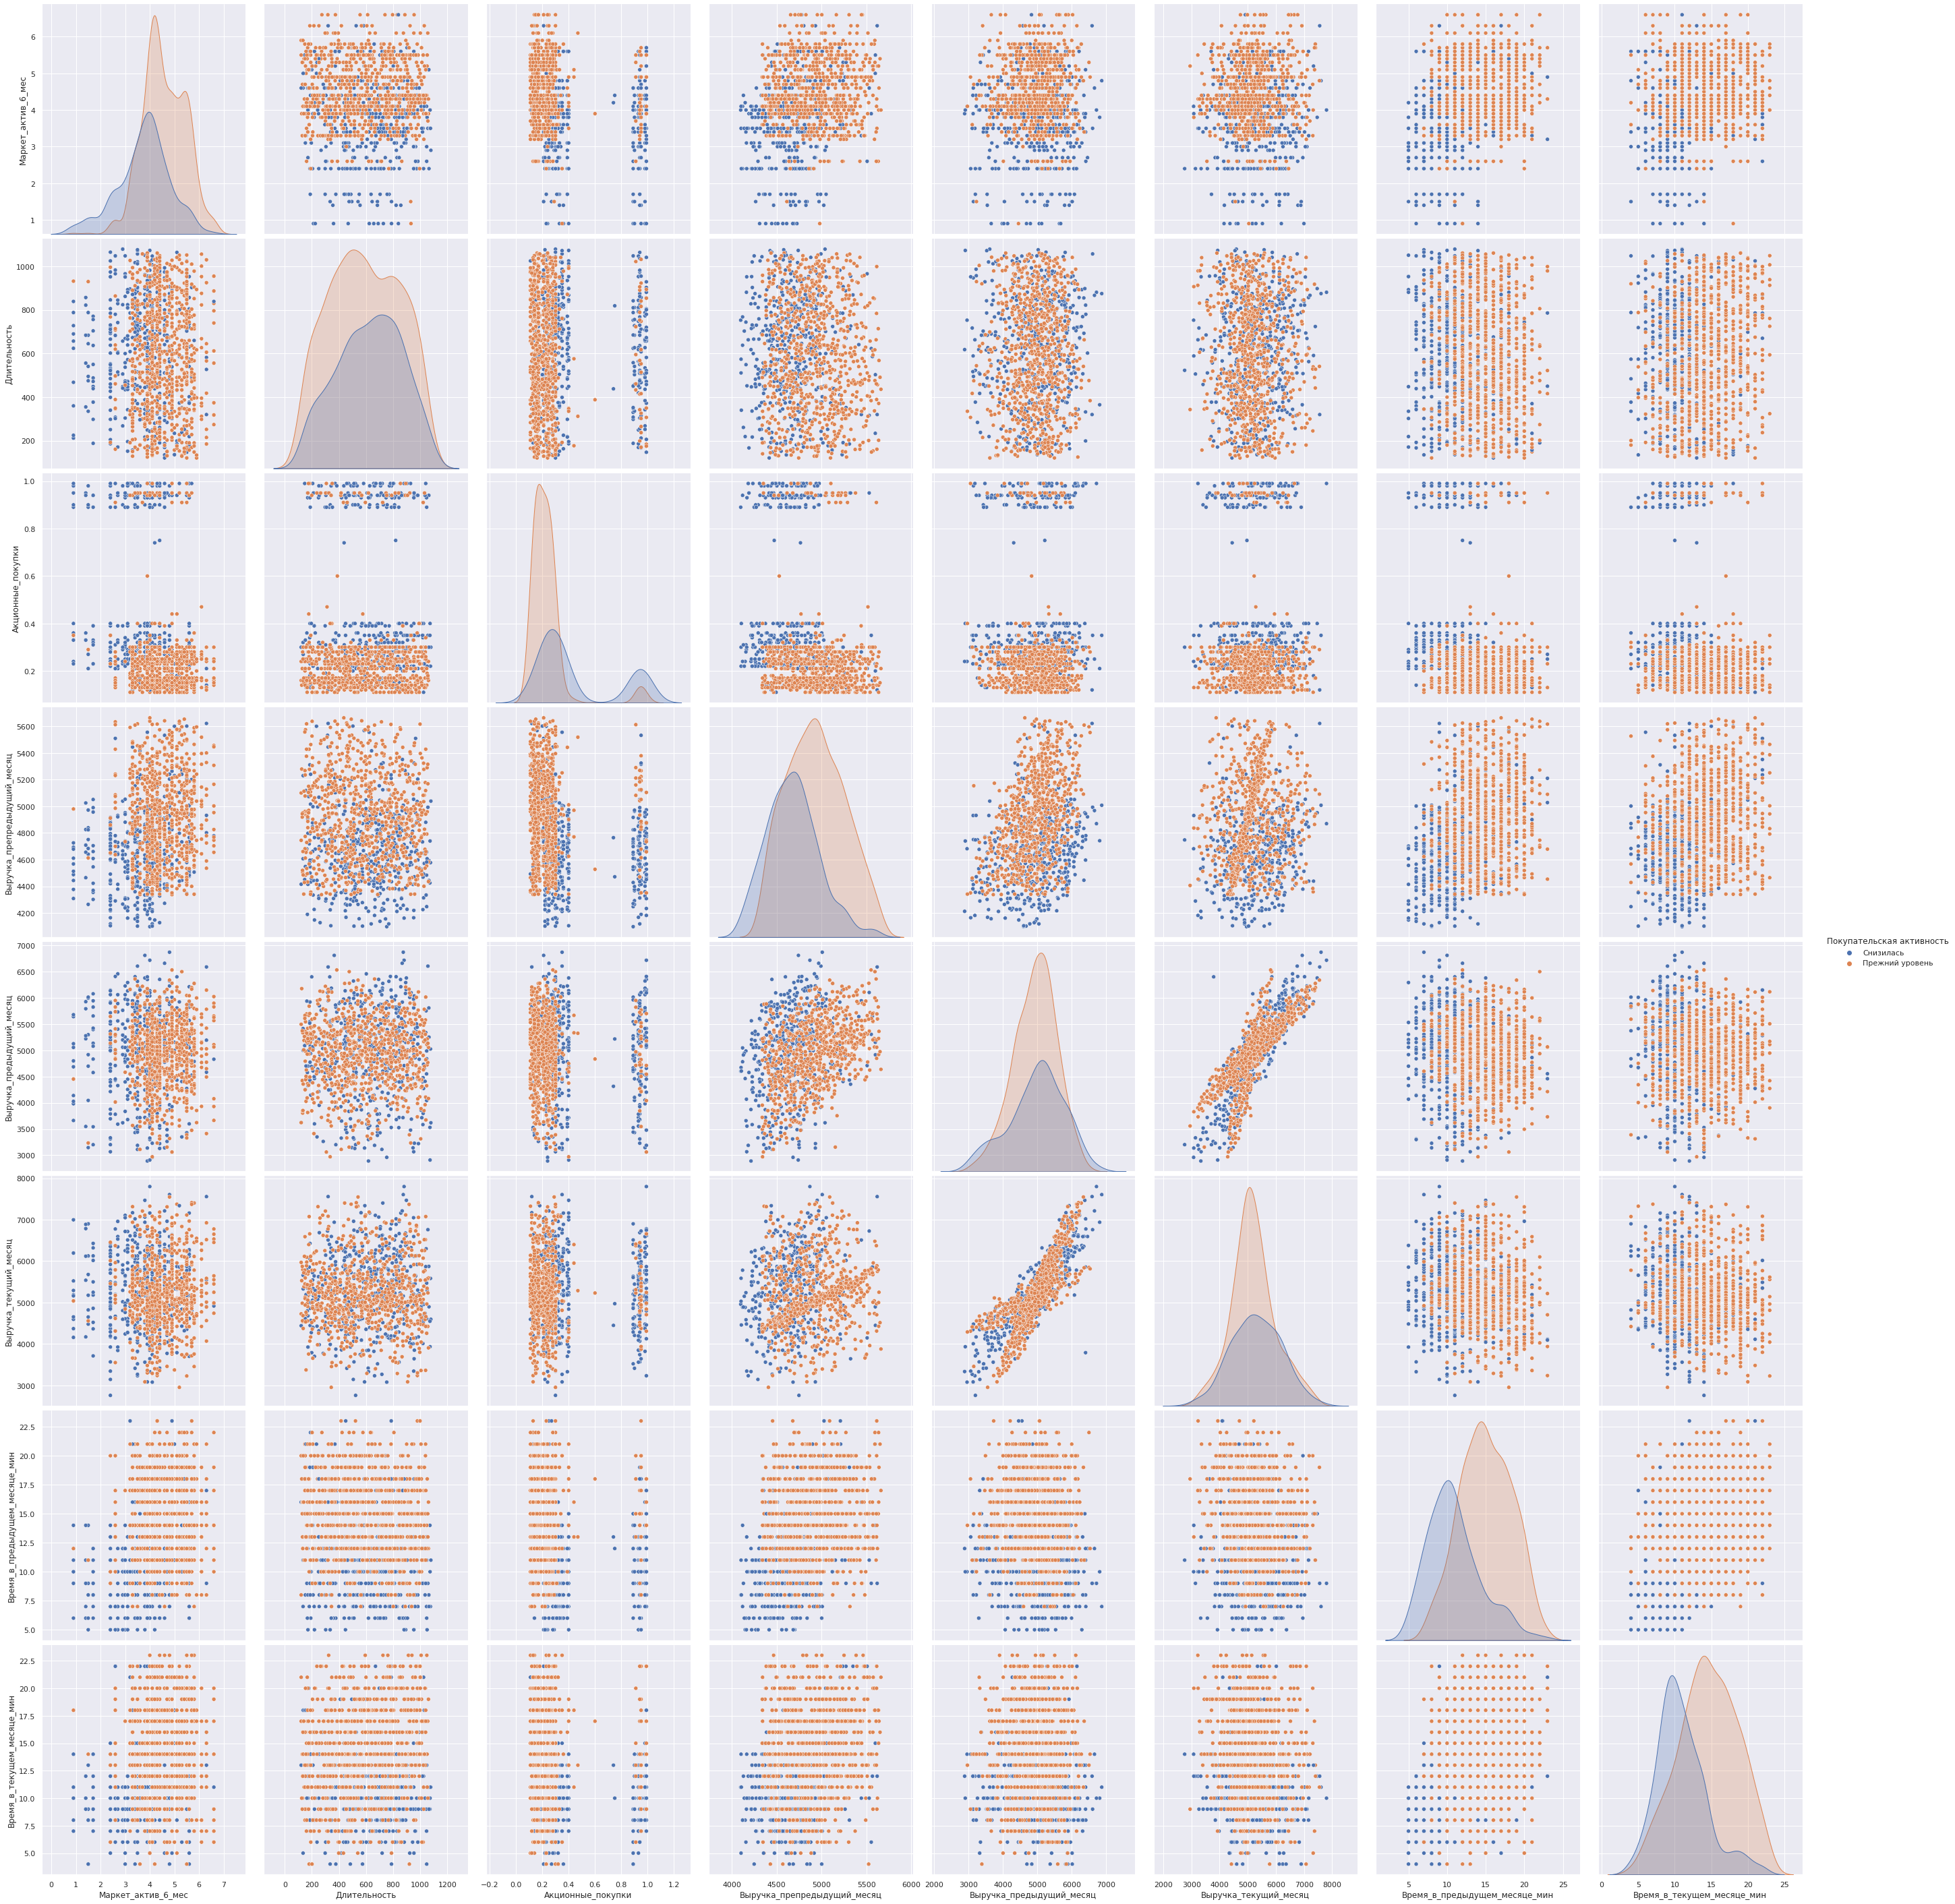

In [68]:
sns.pairplot(
    market[num_cols_market+['Покупательская активность']],
    height=5,
    aspect=.95,
    hue='Покупательская активность')
plt.show()

Активность снижается при слабой маркетинговой работе.
Те, кто совершают больше акционных покупок склонны к снижению активности. 
Средние и высокие показатели выручки демонстрируются среди активных покупателей, которые покупают мало акционных товаров.
Явно видна линейная зависимость между выручкой в текущем и препредыдущем месяце.
Почти всегда максимальное время, проведенное на сайте, говорит о лояльности покупателя.

## Обучение модели

In [69]:
X = market.drop('Покупательская активность', axis = 1)
y = market['Покупательская активность']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = y)

In [71]:
#закодируем строковые классы целевого признака числами
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

#label_encoder.classes_

In [72]:
pred_classes = [0, 1]
print(label_encoder.inverse_transform(pred_classes))

['Прежний уровень' 'Снизилась']


In [73]:
#создание списков количественных и категориальных переменных
cols_ohe = ['Разрешить сообщать', 'Популярная_категория']
cols_ord = ['Тип сервиса']
cols_num = ['Маркет_актив_6_мес', 
            'Длительность', 
            'Акционные_покупки',
            'Выручка_препредыдущий_месяц',
            'Выручка_предыдущий_месяц',
            'Выручка_текущий_месяц',
            'Время_в_предыдущем_месяце_мин',
            'Время_в_текущем_месяце_мин',
            'Маркет_актив_тек_мес',
            'Средний_просмотр_категорий_за_визит', 
            'Неоплаченные_продукты_штук_квартал', 
            'Ошибка_сервиса', 
            'Страниц_за_визит'
           ]
#num_cols_d_market, num_cols_market

In [74]:
#Пайплайн для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='error', 
                       sparse=False))
    ]
)

In [75]:
#Пайплайн для кодирования ранговых признаков
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')),
                 ('ord',  OrdinalEncoder(
                     categories=[['стандарт', 'премиум'],], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
                 ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [76]:
#Пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cols_ohe),
        ('ord', ord_pipe, cols_ord),
        ('num', StandardScaler(), cols_num)
    ], 
    remainder='passthrough'
)

In [77]:
# Итоговый пайплайн, в качестве базовой модели логрег
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)
#LogisticRegression
#DecisionTreeClassifier

In [78]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(st

In [79]:
# выводим предсказанные значения тренировочной выборки
#y_train_pred = pipe_final.predict(X_train)
#(f'Предсказание на обучающей выборке: {y_train_pred}')

Выбор метрики:
Перед нами стоит задача классификации качественной переменной "Покупательская активность". Присутствует дисбаланс классов 62% против 38%. Целевой класс - 1 "снизилась" минорный. Есть корреляция между признаками выручки, а так же нет сильной корреляции между целевым признаком и другими признаками датасета.

Accuracy (сколько раз модель ответила правильно). Это простая метрика, но она бесполезна при дисбалансе классов, мультиколлинеарности и наличии признаков, не связанных с целевым.

Для нас критичны ошибки FN (второго рода), когда модель ошибочно отнесет к классу 0 "Осталась прежней" класс 1 "Снизилась".
В метрике recall минизируются ошибки FN. Когда таких ошибок нет, мы найдем все возможные объекты целевого класса и никого не пропустим. Но FP нам тоже хочется учитывать. В дальнейшем мы будем проводить сегментацию покупателей. Учесть эти требования можно используя метрику f_beta с параметром beta = 1,5.

Метрика roc-auc это компромиссный, более универсальный вариант, который стремится к уменьшению FP и FN и оценивает работу модели более обобщённо, независимо от того, какой порог классификации выбран. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

Предлагаю для построения модели использовать roc-auc.


In [80]:
# вычисляем вероятности предсказания первого класса на тестовой выборке
y_test_pred = pipe_final.predict_proba(X_test)
proba_one_test = y_test_pred[:, 1]
#proba_one_test

In [81]:
(f'Метрика ROC-AUC на тестовой выборке равна {roc_auc_score(y_test, proba_one_test):.4f}')

'Метрика ROC-AUC на тестовой выборке равна 0.8990'

In [82]:
#Параметры для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder и перебором гиперпараметров

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(
            kernel = 'poly', 
            probability=True, 
            random_state=RANDOM_STATE)],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [83]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1)

In [84]:
#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['Разрешить '
                                                                          'сообщать',
         

In [85]:
#вывод лучшей модели
('Лучшая модель и её параметры:', grid.best_params_)

('Лучшая модель и её параметры:',
 {'models': KNeighborsClassifier(n_neighbors=9),
  'models__n_neighbors': 9,
  'preprocessor__num': RobustScaler()})

In [86]:
#выведем результаты подбора
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid.cv_results_)
(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 
#display

rank_test_score  \
286                1   
328                2   
290                3   
302                4   
294                5   
..               ...   
259              352   
6                353   
5                353   
4                353   
7                353   

                                                              param_models  \
286                                    KNeighborsClassifier(n_neighbors=9)   
328                  SVC(kernel='poly', probability=True, random_state=77)   
290  LogisticRegression(penalty='l1', random_state=77, solver='liblinear')   
302  LogisticRegression(penalty='l1', random_state=77, solver='liblinear')   
294  LogisticRegression(penalty='l1', random_state=77, solver='liblinear')   
..                                                                     ...   
259                                    KNeighborsClassifier(n_neighbors=9)   
6                                  DecisionTreeClassifier(random_state=77)   
5                                  DecisionTreeClassifier(random_state=77)   
4                                  DecisionTreeClassifier(random_state=77)   
7                                  DecisionTreeClassifier(random_state=77)   

     mean_test_score  \
286         0.900576   
328         0.900469   
290         0.900307   
302         0.900176   
294         0.900176   
..               ...   
259         0.722027   
6           0.635783   
5           0.635783   
4           0.635783   
7           0.635783   

                                                                                                                                            params  
286                                 {'models': KNeighborsClassifier(n_neighbors=9), 'models__n_neighbors': 9, 'preprocessor__num': RobustScaler()}  
328                  {'models': SVC(kernel='poly', probability=True, random_state=77), 'models__degree': 3, 'preprocessor__num': StandardScaler()}  
290         {'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 1, 'preprocessor__num': RobustScaler()}  
302         {'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 4, 'preprocessor__num': RobustScaler()}  
294         {'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 2, 'preprocessor__num': RobustScaler()}  
..                                                                                                                                             ...  
259                                  {'models': KNeighborsClassifier(n_neighbors=9), 'models__n_neighbors': 2, 'preprocessor__num': 'passthrough'}  
6      {'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': RobustScaler()}  
5      {'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': MinMaxScaler()}  
4    {'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': StandardScaler()}  
7       {'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': 'passthrough'}  

[356 rows x 4 columns]

In [87]:
(f'Метрика ROC-AUC для лучшей модели на тренировочной выборке: {grid.best_score_:.4f}')

'Метрика ROC-AUC для лучшей модели на тренировочной выборке: 0.9006'

In [88]:
y_pred_proba = grid.predict_proba(X_test)
(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba[:, 1]):.4f}')

'Метрика ROC-AUC на тестовой выборке: 0.9042'

In [89]:
y_pred = grid.predict(X_test)
#y_pred

## Анализ важности признаков

In [90]:
# Получение лучших параметров и модели
best_pipeline = grid.best_estimator_

In [91]:
# Преобразование тестовых данных
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

В документации к библиотека sklearn указано, что есть метод  .get_feature_names_out()
Я выяснила, что он появился в версиях 1.0.0 и старше. Установила, но метод не заработал. 
Постаралась представить признаки и их shap значения с помощью датасета. Интерпретация такого способа затруднена. Я не нашла информацию о том, как вывести имена признаков, чтобы их передать на график. В теории практикума признаки передаются через x1, x2.
При передаче пайплайна возникает ошибка при получении категориальных признаков. Приходится получать имена заново.

In [92]:
# Получаем имена признаков после трансформации
ohe_feature_names = best_pipeline.named_steps['preprocessor'].named_transformers_['ohe']['ohe'].get_feature_names_out(cols_ohe)
all_feature_names = np.concatenate([ohe_feature_names, cols_ord, cols_num])
all_feature_names

array(['Разрешить сообщать_нет',
       'Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей', 'Тип сервиса',
       'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки',
       'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц',
       'Выручка_текущий_месяц', 'Время_в_предыдущем_месяце_мин',
       'Время_в_текущем_месяце_мин', 'Маркет_актив_тек_мес',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'], dtype=object)

In [93]:
#ни одна из этих строк не пошла 
#feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
#feature_names = pipe_final.steps[0][1].get_feature_names_out()
#feature_names = grid.best_estimator_[:-1].get_feature_names_out()
#feature_names = grid.get_feature_names_out()
#feature_names = pipe_final[:-1].get_feature_names_out()

In [94]:
sklearn.__version__

'1.0'

In [95]:
# Обучение модели на всей обучающей выборке
best_model = best_pipeline.named_steps['models']
best_model.fit(best_pipeline.named_steps['preprocessor'].transform(X_train), y_train)

KNeighborsClassifier(n_neighbors=9)

In [96]:
#feature_names = best_pipeline.named_steps['preprocessor'][:-1].get_feature_names_out()

Для моделей, не основанных на деревьях (таких как KNeighbors), рекомендуется использовать KernelExplainer. Однако он может быть вычислительно затратным для больших наборов данных. Поэтому часто используют подвыборку для объяснений. KernelExplainer считает очень медленно, Explainer справляется быстрее.

In [97]:
# Создание эксплайнера SHAP
# Используем подвыборку для ускорения вычислений
sample_size = 50  # Размер подвыборки для фона
background = X_train.sample(sample_size, random_state=RANDOM_STATE)
background_preprocessed = best_pipeline.named_steps['preprocessor'].transform(background)
explainer = shap.Explainer(best_model.predict_proba, background_preprocessed)

In [98]:
# Вычисление SHAP значений для тестовой выборки (подвыборки)
shap_sample = X_test.sample(sample_size, random_state=RANDOM_STATE)
shap_sample_preprocessed = best_pipeline.named_steps['preprocessor'].transform(shap_sample)

In [99]:
# Вычисление SHAP значений
shap_values = explainer.shap_values(shap_sample_preprocessed)

PermutationExplainer explainer: 51it [00:52,  1.19s/it]                        


In [100]:
#shap_values[...,1]

In [101]:
# Проверим форму shap_values
(np.shape(shap_values))

(50, 20, 2)

Для 2 классов, 50 значений, 20 признаков. Чтобы построить визуализацию, необходимо сделать двумерный срез. Поскольку у нас целевой класс 1, то сделаем срез по этому классу. 

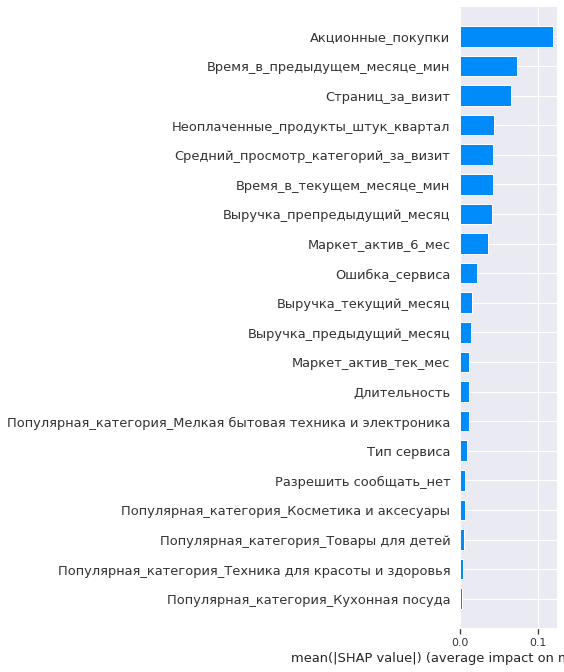

In [102]:
# Визуализация важности признаков
shap.summary_plot(shap_values[..., 1], plot_type='bar', feature_names=all_feature_names)
plt.show()

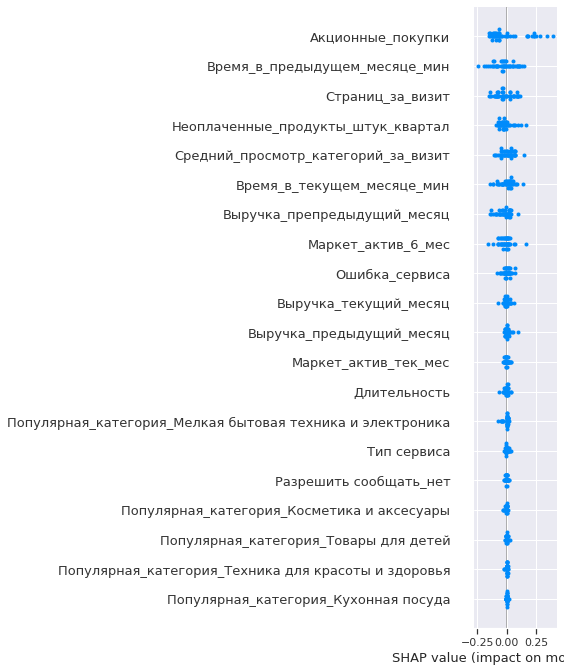

In [103]:
shap.summary_plot(shap_values[..., 1], feature_names=all_feature_names)
plt.show()

Анализ важности признаков показал, что наиболее значимыми являются акционные покупки и время, проведенное на сайте, а так же кол-ва страниц за визит.  Вместе с тем, то, какой категории отдает предпочтение покупатель, мало влияет на качество модели.
Оказывается тип сервиса не имеет значения для лояльности клиента. Получается на данном этапе нет необходимости разработки специальных преимуществ для покупателей, потребляющих премиальный тип сервиса.

## Выделение сегментов покупателей

Руководство компании выбрало стратегию удержания покупателей с помощью  персонализированных предложений. При этом важно максимизировать прибыль компании, то есть выбрать крупный сегмент покупателей с высокой вероятностью снижения активности при этом приносящих высокую прибыль. 
На этапе исследовательского анализа мы определили, что прибыль распределена нормально в рабочем диапазона от 3.3 до 4.67 с медианой 4. 
Нас интересует прибыль выше среднего, т е будем анализировать диапазон от 4.
Для того, чтобы определить по какому признаку сегментировать покупателей, добавим данные о вероятности попадания в класс снижения активности.

In [104]:
X_test['Вероятность'] = y_pred_proba[:, 1]
X_test.sample(5)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
216624    стандарт                 да                 5.4   
215664     премиум                 да                 3.4   
216052    стандарт                 да                 4.3   
216176    стандарт                 да                 5.2   
216082    стандарт                нет                 4.0   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
216624                     5           806               0.17   
215664                     4           822               0.21   
216052                     4           925               0.13   
216176                     3           343               0.30   
216082                     3           414               0.23   

                        Популярная_категория  \
id                                             
216624                     Домашний текстиль   
215664                       Кухонная посуда   
216052  Мелкая бытовая техника и электроника   
216176                 Косметика и аксесуары   
216082                     Домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
216624                                    6   
215664                                    3   
216052                                    3   
216176                                    4   
216082                                    6   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
216624                                   1               8                11   
215664                                   4               2                 3   
216052                                   0               5                10   
216176                                   1               5                 9   
216082                                   1               6                13   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
216624                       5096.0                    5565.5   
215664                       4944.0                    6402.0   
216052                       5408.0                    5898.5   
216176                       4407.0                    3558.0   
216082                       5145.0                    4224.0   

        Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
id                                                             
216624                 6102.4                           22.0   
215664                 7019.5                            8.0   
216052                 6453.6                           12.0   
216176                 2952.2                           18.0   
216082                 3555.8                           14.0   

        Время_в_текущем_месяце_мин  Вероятность  
id                                               
216624                        19.0     0.111111  
215664                        11.0     0.888889  
216052                        18.0     0.000000  
216176                         9.0     0.333333  
216082                        14.0     0.000000

In [105]:
X_train['Вероятность'] = grid.predict_proba(X_train)[:,1]
X_train.sample(5)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215360     премиум                 да                 3.9   
216630    стандарт                 да                 4.4   
215862    стандарт                 да                 5.8   
216388    стандарт                 да                 4.3   
216309    стандарт                 да                 4.2   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215360                     3           623               0.35   
216630                     4           488               0.29   
215862                     4           408               0.16   
216388                     4           356               0.15   
216309                     4           633               0.28   

                        Популярная_категория  \
id                                             
215360                       Кухонная посуда   
216630                     Домашний текстиль   
215862  Мелкая бытовая техника и электроника   
216388                       Кухонная посуда   
216309        Техника для красоты и здоровья   

        Средний_просмотр_категорий_за_визит  \
id                                            
215360                                    3   
216630                                    4   
215862                                    4   
216388                                    3   
216309                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215360                                   1               4                 7   
216630                                   4               7                 4   
215862                                   2               3                12   
216388                                   2               4                 6   
216309                                   3               4                 9   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215360                       5555.0                    5304.5   
216630                       4833.0                    5322.0   
215862                       5222.0                    5330.0   
216388                       5171.0                    5277.5   
216309                       5159.0                    5607.0   

        Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
id                                                             
215360                 5834.9                            9.0   
216630                 5875.8                           17.0   
215862                 5553.6                           12.0   
216388                 5499.8                           20.0   
216309                 5348.3                           22.0   

        Время_в_текущем_месяце_мин  Вероятность  
id                                               
215360                         6.0     0.666667  
216630                        16.0     0.333333  
215862                        21.0     0.000000  
216388                        12.0     0.000000  
216309                        14.0     0.111111

In [106]:
data = pd.concat([X_train, X_test])
data.sample(5)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215748    стандарт                нет                 4.3   
215668     премиум                 да                 4.4   
215856    стандарт                 да                 4.3   
215525    стандарт                 да                 3.0   
215402     премиум                 да                 3.0   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215748                     4           534               0.18   
215668                     4           343               0.94   
215856                     4           543               0.17   
215525                     4           558               0.32   
215402                     5           954               0.93   

                  Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                            
215748                 Кухонная посуда                                    3   
215668                Товары для детей                                    2   
215856  Техника для красоты и здоровья                                    6   
215525                Товары для детей                                    1   
215402                Товары для детей                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215748                                   1               4                10   
215668                                   9               2                 2   
215856                                   3               5                11   
215525                                   2               4                 1   
215402                                   2               4                 6   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215748                       4552.0                    5083.0   
215668                       4723.0                    5567.5   
215856                       4376.0                    3652.0   
215525                       4639.0                    4769.5   
215402                       4702.0                    4918.0   

        Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
id                                                             
215748                 5673.2                           13.0   
215668                 5293.2                            6.0   
215856                 4409.9                           13.0   
215525                 4984.0                            9.0   
215402                 4940.1                            5.0   

        Время_в_текущем_месяце_мин  Вероятность  
id                                               
215748                        13.0     0.333333  
215668                         9.0     1.000000  
215856                        20.0     0.000000  
215525                        10.0     0.888889  
215402                         5.0     1.000000

In [107]:
money = money.set_index('id')
data_profit = data.join(money)
data_profit.sample(5)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215898    стандарт                 да                 5.5   
215763    стандарт                нет                 3.7   
216550     премиум                 да                 4.4   
215439     премиум                нет                 3.4   
215967    стандарт                нет                 4.1   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215898                     4           703               0.14   
215763                     3           300               0.23   
216550                     5           744               0.16   
215439                     5           448               0.28   
215967                     3           775               0.15   

                        Популярная_категория  \
id                                             
215898  Мелкая бытовая техника и электроника   
215763  Мелкая бытовая техника и электроника   
216550  Мелкая бытовая техника и электроника   
215439                      Товары для детей   
215967                 Косметика и аксесуары   

        Средний_просмотр_категорий_за_визит  \
id                                            
215898                                    2   
215763                                    3   
216550                                    3   
215439                                    4   
215967                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215898                                   1               3                 7   
215763                                   3               4                 4   
216550                                   2               4                 8   
215439                                   2               2                 7   
215967                                   2               4                 4   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215898                       4346.0                    3428.0   
215763                       5228.0                    6219.5   
216550                       4830.0                    4371.0   
215439                       4551.0                    5484.0   
215967                       4382.0                    5492.0   

        Выручка_текущий_месяц  Время_в_предыдущем_месяце_мин  \
id                                                             
215898                 4353.6                           18.0   
215763                 7208.8                           12.0   
216550                 4898.8                           16.0   
215439                 5833.7                            9.0   
215967                 6584.0                            8.0   

        Время_в_текущем_месяце_мин  Вероятность  Прибыль  
id                                                        
215898                        11.0     0.555556     3.10  
215763                        14.0     0.111111     2.43  
216550                        13.0     0.111111     4.26  
215439                         9.0     0.888889     6.33  
215967                        22.0     0.444444     4.88

In [108]:
data_profit.shape

(1297, 18)

Сделаем срез из покупателей с высокой прибылью.

In [109]:
df = data_profit.query('Прибыль > 4')
df.shape

(664, 18)

С помощью диаграммы рассеяния определим признаки, которые влияют на прибыль и вероятность снижения активности у лучшей модели.

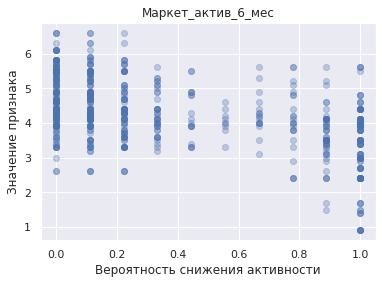

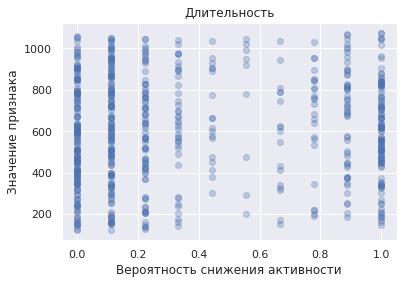

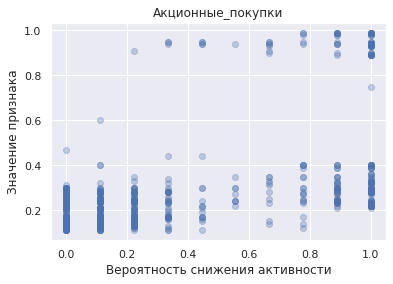

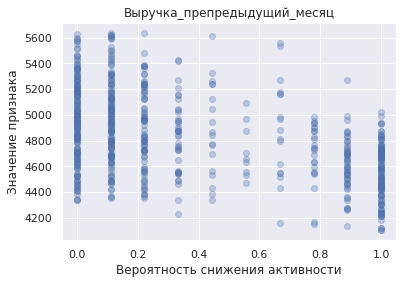

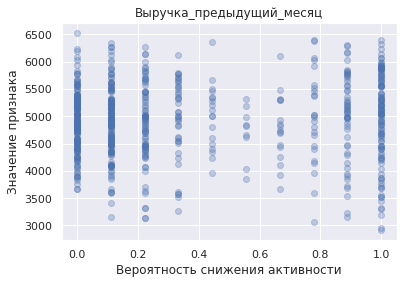

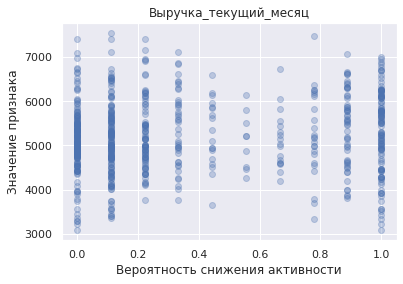

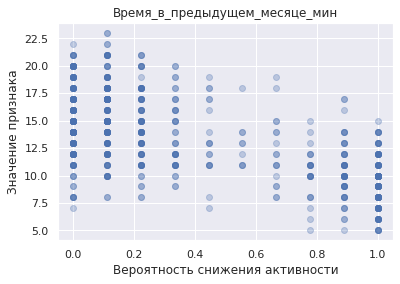

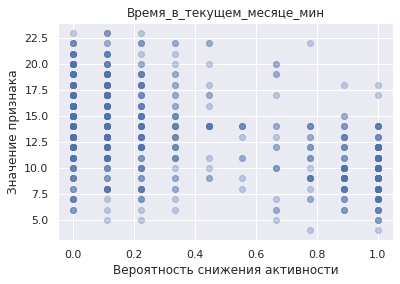

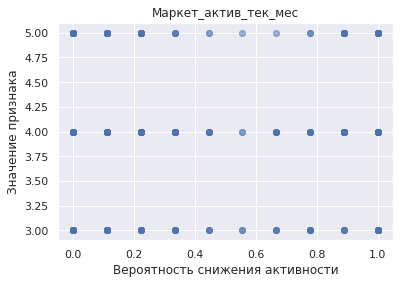

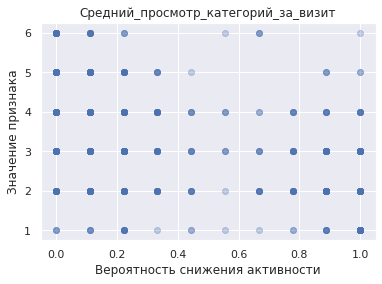

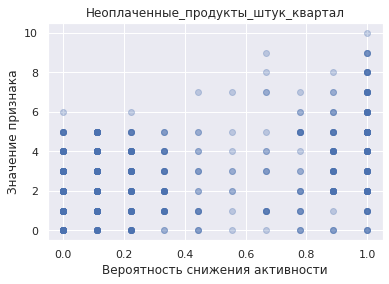

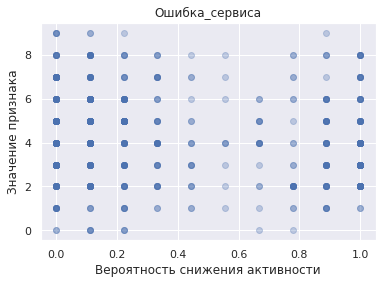

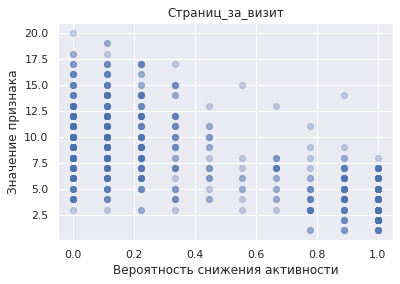

In [110]:
for name in cols_num:
    plt.figure()
    plt.scatter(x=df['Вероятность'], y=df[name], alpha=0.3)
    plt.title(name)
    plt.xlabel('Вероятность снижения активности')
    plt.ylabel(f'Значение признака')
    
plt.show()

Итак, высокая вероятность снижения активности (более 0,8) наблюдается у покупателей с высокой прибылью, которые имеют:
значение маркетинговых коммуникаций меньше 5;
долю акционных покупок более 0,9
выручку менее 4300,
показатель времени, проводимого на сайте менее 7 минут в предыдущем месяце и 5 минут в текущем,
просмотр 1 категории за визит,
более 6 продуктов в корзине, которые не оплачены,
просмотр менее 3 страниц за визит.

Нами установлено, что самыми важными признаками при работе модели являются:
Страниц_за_визит,
Акционные_покупки,	
Время_в_предыдущем_месяце_мин.
СФормируем сегмент.

In [111]:
segment = df.query('Страниц_за_визит < 3 or Акционные_покупки > 0.9 or Время_в_предыдущем_месяце_мин < 7')
segment.shape

(110, 18)

In [112]:
segment

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215503    стандарт                 да                 2.4   
215510    стандарт                 да                 3.8   
215699    стандарт                нет                 4.1   
215832    стандарт                нет                 4.1   
215485    стандарт                 да                 3.5   
...            ...                ...                 ...   
215738     премиум                нет                 4.6   
215497     премиум                 да                 5.6   
216357    стандарт                нет                 4.1   
215909     премиум                 да                 4.9   
215398     премиум                 да                 3.5   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215503                     5           638               0.24   
215510                     4           324               0.22   
215699                     3           811               0.93   
215832                     3           206               0.99   
215485                     4           720               0.99   
...                      ...           ...                ...   
215738                     5           187               0.23   
215497                     5           719               0.28   
216357                     4           184               0.99   
215909                     4           475               0.94   
215398                     5           882               0.22   

                        Популярная_категория  \
id                                             
215503                     Домашний текстиль   
215510        Техника для красоты и здоровья   
215699                 Косметика и аксесуары   
215832                      Товары для детей   
215485                 Косметика и аксесуары   
...                                      ...   
215738  Мелкая бытовая техника и электроника   
215497  Мелкая бытовая техника и электроника   
216357                       Кухонная посуда   
215909                 Косметика и аксесуары   
215398  Мелкая бытовая техника и электроника   

        Средний_просмотр_категорий_за_визит  \
id                                            
215503                                    1   
215510                                    2   
215699                                    4   
215832                                    4   
215485                                    1   
...                                     ...   
215738                                    1   
215497                                    1   
216357                                    3   
215909                                    2   
215398                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215503                                   5               2                 1   
215510                                   7               2                 2   
215699                                   1               5                 8   
215832                                   4               3                 4   
215485                                   2               4                 7   
...                                    ...             ...               ...   
215738                                   3               3                 2   
215497                                   2               7                 1   
216357                                   4               5                 7   
215909                                   3               5                10   
215398                                   2               6                 3   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                      

Нами сформирован сегмент из 110 покупателей, с которыми необходимо работать, чтобы они продолжали приносить прибыл компании и их покупательская активность не снижалась.
Маркетинговые коммуникации имеют важное значение для поддержания интереса клиента, но это не должна быть реклама акционных товаров.
Важно, чтобы покупатель проводил больше времени на сайте, просматривал не менее 3 страниц за визит из разных категорий. При этом нужно стимулировать не откладывать покупки.
Этому описанию соотвтетсвует решение о запуске регулярных маркетинговых коммуникаций (в том числе на самом сайте, чтобы охватить аудиторию, которая не приемлет рассылки), содержащих информацию о трех и более товарах из двух и более категорий. Причем, например, при оплате в течение короткого периода (суток) возможно предусмотреть начисление бонусов или выдачу промокодов на следующую покупку.

Подставим желаемые показатели в подборку segment и посмотри сколько покупателей удастся сохранить.

In [113]:
segment_test = segment.drop('Вероятность', axis = 1)

Сделаем прогноз с учетом желаемой корректировки параметров.

In [114]:
segment_test.loc[segment_test['Страниц_за_визит'] < 4, 'Страниц_за_визит'] = 10
segment_test.loc[segment_test['Акционные_покупки'] >= 0.9, 'Акционные_покупки'] = 0.8
segment_test.loc[segment_test['Время_в_предыдущем_месяце_мин'] <= 7, 'Время_в_предыдущем_месяце_мин'] = 15
#segment_test['Страниц_за_визит']
#segment_test['Акционные_покупки']

In [115]:
y_pred_proba_segment = grid.predict_proba(segment_test)[:,1]
y_pred_proba_segment

array([1.        , 0.66666667, 0.55555556, 1.        , 1.        ,
       0.88888889, 0.88888889, 1.        , 0.77777778, 0.33333333,
       1.        , 0.88888889, 0.88888889, 1.        , 0.88888889,
       1.        , 0.66666667, 0.77777778, 0.33333333, 0.77777778,
       1.        , 0.22222222, 0.66666667, 0.88888889, 0.88888889,
       1.        , 0.77777778, 0.66666667, 0.55555556, 1.        ,
       1.        , 1.        , 0.88888889, 0.66666667, 0.88888889,
       0.55555556, 0.22222222, 0.88888889, 1.        , 1.        ,
       0.44444444, 1.        , 1.        , 0.44444444, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.88888889, 1.        ,
       1.        , 0.88888889, 0.77777778, 0.66666667, 0.66666667,
       0.33333333, 0.88888889, 0.88888889, 1.        , 0.22222222,
       1.        , 0.88888889, 0.66666667, 0.44444444, 1.        ,
       1.        , 1.        , 0.44444444, 0.77777778, 1.        ,
       0.66666667, 1.        , 1.        , 0.22222222, 1.     

In [116]:
y_pred_proba_segment_0 = grid.predict_proba(segment_test)[:,0]

In [117]:
segment['Нов вероятность'] = y_pred_proba_segment
segment.head(10)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215503    стандарт                 да                 2.4   
215510    стандарт                 да                 3.8   
215699    стандарт                нет                 4.1   
215832    стандарт                нет                 4.1   
215485    стандарт                 да                 3.5   
215638    стандарт                 да                 2.4   
215402     премиум                 да                 3.0   
215573    стандарт                 да                 4.1   
215478    стандарт                 да                 4.1   
215432    стандарт                нет                 4.1   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215503                     5           638               0.24   
215510                     4           324               0.22   
215699                     3           811               0.93   
215832                     3           206               0.99   
215485                     4           720               0.99   
215638                     4           549               0.30   
215402                     5           954               0.93   
215573                     4           706               0.99   
215478                     4           753               0.24   
215432                     4           377               0.24   

                  Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                            
215503               Домашний текстиль                                    1   
215510  Техника для красоты и здоровья                                    2   
215699           Косметика и аксесуары                                    4   
215832                Товары для детей                                    4   
215485           Косметика и аксесуары                                    1   
215638                 Кухонная посуда                                    1   
215402                Товары для детей                                    3   
215573                 Кухонная посуда                                    2   
215478                Товары для детей                                    2   
215432                Товары для детей                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215503                                   5               2                 1   
215510                                   7               2                 2   
215699                                   1               5                 8   
215832                                   4               3                 4   
215485                                   2               4                 7   
215638                                   6               3                 2   
215402                                   2               4                 6   
215573                                   6               2                 6   
215478                                   8               2                 2   
215432                                   3               2                 1   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215503                       4119.0                    5046.0   
215510                       4814.0                    4244.0   
215699                       4518.0                    4441.5   
215832                       4662.0                    5065.5   
215485                       4234.0                    4201.0   
215638                       4436.0                    5195.0   
215402                       4702.0                    4918.0  

In [118]:
segment['Нов вероятность_0'] = y_pred_proba_segment_0
segment.head(10)

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215503    стандарт                 да                 2.4   
215510    стандарт                 да                 3.8   
215699    стандарт                нет                 4.1   
215832    стандарт                нет                 4.1   
215485    стандарт                 да                 3.5   
215638    стандарт                 да                 2.4   
215402     премиум                 да                 3.0   
215573    стандарт                 да                 4.1   
215478    стандарт                 да                 4.1   
215432    стандарт                нет                 4.1   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215503                     5           638               0.24   
215510                     4           324               0.22   
215699                     3           811               0.93   
215832                     3           206               0.99   
215485                     4           720               0.99   
215638                     4           549               0.30   
215402                     5           954               0.93   
215573                     4           706               0.99   
215478                     4           753               0.24   
215432                     4           377               0.24   

                  Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                            
215503               Домашний текстиль                                    1   
215510  Техника для красоты и здоровья                                    2   
215699           Косметика и аксесуары                                    4   
215832                Товары для детей                                    4   
215485           Косметика и аксесуары                                    1   
215638                 Кухонная посуда                                    1   
215402                Товары для детей                                    3   
215573                 Кухонная посуда                                    2   
215478                Товары для детей                                    2   
215432                Товары для детей                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215503                                   5               2                 1   
215510                                   7               2                 2   
215699                                   1               5                 8   
215832                                   4               3                 4   
215485                                   2               4                 7   
215638                                   6               3                 2   
215402                                   2               4                 6   
215573                                   6               2                 6   
215478                                   8               2                 2   
215432                                   3               2                 1   

        Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
id                                                              
215503                       4119.0                    5046.0   
215510                       4814.0                    4244.0   
215699                       4518.0                    4441.5   
215832                       4662.0                    5065.5   
215485                       4234.0                    4201.0   
215638                       4436.0                    5195.0   
215402                       4702.0                    4918.0  

In [119]:
pr = segment[segment['Нов вероятность_0']> 0.5] 
pr.shape

(17, 20)

Если указанные мероприятия на выделенной выборке поднимут показатели поведения на сайтеи немного снизят долю акционных покупок как указано выше, то из 110 покупателей 17 перейдут в категорию с прежней активностью при стандартном пороге разделения классов.

## Итоговые выводы

Для анализа было представлено 4 файла. 
В ходе предобработки 3 файла были объединены для создания датафрейма, пригодного для обучения моделей и содержащего все предлагаемые признаки. Данные признаны полными и достаточными для обучения, распределения похожи на нормальные, присутствует дисбаланс классов.

Проведен исследовательский и корреляционный анализ данных с целью выявления зависимостей и определения подходящих для обучения признаков, устранена мультиколлинеарность, утечки данных не обнаружено. Визуализировано распределение статуса покупательской активности под взаимным влиянием признаков. 

Выполнена подготовка данных для обучения модели. Для построения модели использованы пайплайны кодировки данных и пайплайн подбора гиперпараметров. Численные данные отмасштабированы, качественные - закодированы для улучшения точности работы модели. Обоснован выбор метрики roc-auc. На подборе лучшей оказалась модель KNeighborsClassifier(n_neighbors=9) со стандартизатором RoubustScaler.

Произведен анализ важности параметров. Наболее важными для присвоения класса снижения активности являются: 'Акционные_покупки','Время_в_предыдущем_месяце_мин', 'Страниц_за_визит'.

На основании предсказаний лучшей модели и анализа важности с учетом максимизации прибыли сделан срез данных на 110 пользователей, на которых необходимо направить активные действия по поддержанию их активности.
Установлено, что маркетинговые коммуникации имеют важное значение для поддержания интереса клиента, но это не должна быть реклама акционных товаров.
Важно, чтобы покупатель проводил больше времени на сайте, просматривал не менее 3 страниц за визит из разных категорий. 
При этом нужно стимулировать не откладывать покупки.
Рекомендацией для заказчика является решение о запуске регулярных маркетинговых коммуникаций (в том числе на самом сайте, чтобы охватить аудиторию, которая не приемлет рассылки), содержащих информацию о трех и более товарах из двух и более категорий. Причем, например, при оплате в течение короткого периода (суток) возможно предусмотреть начисление бонусов или выдачу промокодов на следующую покупку.